<div style='background-color: #fff3cd; border: 1px solid #ffeaa7; border-radius: 4px; padding: 15px; margin: 10px 0; border-left: 4px solid #f39c12;'>
<h3 style='color: #856404; margin-top: 0;'>⚠️ EXECUTION WARNING</h3>
<p style='color: #856404; margin-bottom: 0;'><strong>This notebook may not execute properly in the current environment.</strong></p>
<p style='color: #856404; margin-bottom: 0;'>Some cells may have failed during automated testing. Please review the notebook content and test manually before use.</p>
<p style='color: #856404; margin-bottom: 0; font-size: 0.9em;'><em>Generated during CI/CD pipeline - some outputs may be incomplete or missing.</em></p>
</div>


![STScI Logo](../../../_static/stsci_header.png)

<a id="top"></a>
# HST Exception Report - Investigate your ACS Data

## Learning Goals
In this notebook, we will walk through steps to check your ACS data and observing logs for possible data quality problems indicated by an HST Exception Report and determine if a HOPR or Help Desk ticket needs to be filed.

By the end of this notebook, you will learn to:
- Download your data
- Display the data
- Check data quality and any anomalies
- Inspect JIF header keywords for problems
- Run hst1pass on your data and evaluate the results
- Determine if a HOPR or help desk ticket is warranted

## Table of Contents

[Introduction](#intro) <br>
[Imports](#imports) <br>
[Download the Data](#download) <br>
[1. View data](#view) <br>
[2. Inspect JIF header keywords](#inspect) <br>
[3. Check jitter](#jitter) <br>
[4. Check PSF quality with hst1pass (Optional)](#hst1pass) <br>
[5. Summary & Additional Resources](#summary) <br>
[About this Notebook](#about) <br>
[Citations](#citations)

<a id="intro"></a>
## Introduction 
[HST exception reports](https://www.stsci.edu/hst/observing/post-observation/exception-reports) are sent via email to the PIs of programs that encounter observing problems during a given visit. Often times these are due to guide star acquisition failures, but there can be other causes, including unexpected safings of the telescope. Sometimes a report is sent out of an abundance of caution, in that the observing problem in question did not affect the data in the exception report. If you receive one of these reports, it is highly recommended that you inspect your data and the observing logs immediately in order to determine if your data quality is affected in any way. 

If you determine your data are compromised by an observing problem, you can file a [Hubble Observation Problem Report (HOPR)](https://www.stsci.edu/hst/observing/post-observation/reporting-problems). There is a 90-day time limit from the date the data were made available to file a HOPR.

If you have any issues with this notebook or any further questions, please contact the [ACS Help Desk](https://stsci.service-now.com/hst).

Some text and code in this notebook was adapted from the [WFC3 Exception Report Checklist notebook (Kuhn 2022)](https://spacetelescope.github.io/hst_notebooks/notebooks/WFC3/exception_report/wfc3_exception_report.html).

<a id="imports"></a>
## Imports

We recommend installing the `stenv` Conda environment maintained by STScI. Instructions, including installation of a Conda distribution, can be found in the [stenv documentation](https://stenv.readthedocs.io/en/latest/getting_started.html). If you already have Conda, and would prefer to create an environment with only the packages required by this notebook, please see the `requirements.txt` file included in this notebook's repository.

Finally, this notebook contains an optional step to check PSF quality with a Fortran software package `hst1pass`. Instructions to install Fortran, download and compile `hst1pass`, download a PSF model, and run `hst1pass` are provided in Step [6. Check PSF quality with hst1pass (Optional)](#hst1pass).

For the Python-based steps in this notebook, we import: <br>

| Package Name                        | Purpose                               |
|:------------------------------------|:--------------------------------------|
| `glob`                              | creating list of files                |
| `shutil`                            | directory clean up                    |
| `os`                                | setting environment variables         |
| `urllib`                            | downloading hst1pass files            |
| `astroquery.mast.Observations`      | downloading data from MAST            |
| `astropy.io.fits`                   | opening and modifying fits files      |
| `astropy.io.ascii`                  | reading text files                    |
| `astropy.visualization.simple_norm` | normalize image for display           |
| `matplotlib.pyplot`                 | plotting and displaying images        |

In [1]:
import glob
import shutil
import os
import urllib
import subprocess
from astroquery.mast import Observations
from astropy.io import fits, ascii
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

<a id="download"></a>
## Download the Data 

Here we download an example dataset with `astroquery.mast`. We choose visit 57 from program [16380 (PI Chiaberge)](https://www.stsci.edu/hst-program-info/program/?program=16380), which consists of three ACS/WFC observations: `JEG057010`, `JEG057020`, and `JEG057030`. Each contains two exposures. The target is a region of Omega Centauri, a Milky Way globular cluster, so successful exposures contain a large population of resolved stars. We download the FLT, JIF, and JIT files, and move them into a directory named for the program ID. 

To use this notebook with your data, edit the cell below with your program ID and exposure IDs ([association names or IPPPSSOOTs](https://archive.stsci.edu/hlsp/ipppssoot.html)), which are listed in your exception report.

For more information on this method of downloading data, see the documentation for [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html). This list of [parameters](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html) for the `query_criteria()` function may be particularly useful. Other methods for downloading data include the [MAST HST Search](https://mast.stsci.edu/search/ui/#/hst) and the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html), the latter of which includes data from missions other than HST.

In [2]:
# Edit this cell with your info
program_id = 16380
exp_id = ['JEG057010', 'JEG057020', 'JEG057030']
data_products = ['FLT', 'JIF', 'JIT']

In [3]:
program_dir = '{}/p{}'.format(os.getcwd(), program_id)

# Check if directory for program exists already
try:
    os.mkdir(program_dir)
except Exception:
    print('Directory {} exists.\n'.format(program_dir))

# Check that all dataset names are 9 characters long
# if not, add a q to the end
datasets = ['{}q'.format(set) if len(set) == 8 else set for set in exp_id]

print('Visits to be downloaded')
print('{}\n'.format(datasets))

# Query MAST for datasets
obs_table = Observations.query_criteria(obs_id=datasets)
product_table = Observations.get_product_list(obs_table)
files_for_download = product_table['productFilename']
download_table = Observations.download_products(product_table, mrp_only=False,
                                                productSubGroupDescription=data_products)

# For convenience move downloaded files to program dir and remove empty download dir
for file in download_table['Local Path']:
    destination = os.path.join(program_dir, os.path.basename(file))
    if not os.path.exists(destination):
        shutil.move(file, program_dir)
    else:
        print(f"File {destination} already exists, skipping.")
    
shutil.rmtree('mastDownload')

Directory /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_exception_report/p16380 exists.

Visits to be downloaded
['JEG057010', 'JEG057020', 'JEG057030']



 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


File /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_exception_report/p16380/jeg057cjq_flt.fits already exists, skipping.
File /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_exception_report/p16380/jeg057chq_flt.fits already exists, skipping.
File /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_exception_report/p16380/jeg057coq_flt.fits already exists, skipping.
File /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_exception_report/p16380/jeg057021_jif.fits already exists, skipping.
File /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_exception_report/p16380/jeg057021_jit.fits already exists, skipping.
File /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_exception_report/p16380/jeg057cmq_flt.fits already exists, skipping.
File /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_exception_report/p16380/jeg057cxq_flt.fits already exists, skipping.
File /home/runner/work/hst_noteboo

<a id="view"></a>
## 1. View data 

Next, we use `matplotlib.pyplot.imshow` to display the SCI arrays of the FLT images. We also print the filter information for each image at the top of the plot. In some cases, a quick visual inspection can reveal poor data quality due to guiding problems. In other cases, a deeper level of analysis is needed to determine if there are problems with the data.

In [4]:
flt_files = sorted(glob.glob(f'p{program_id}/*flt.fits'))

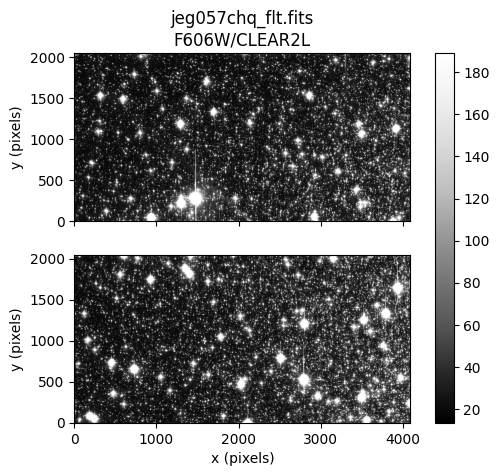

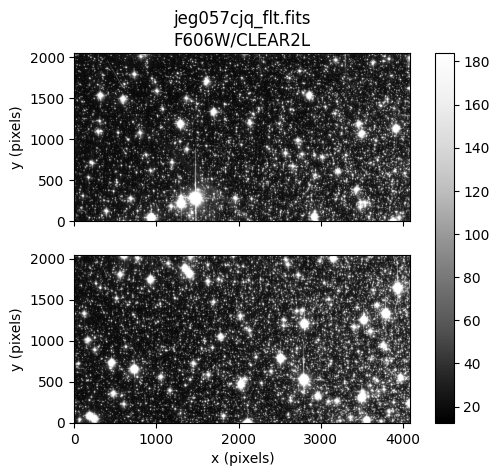

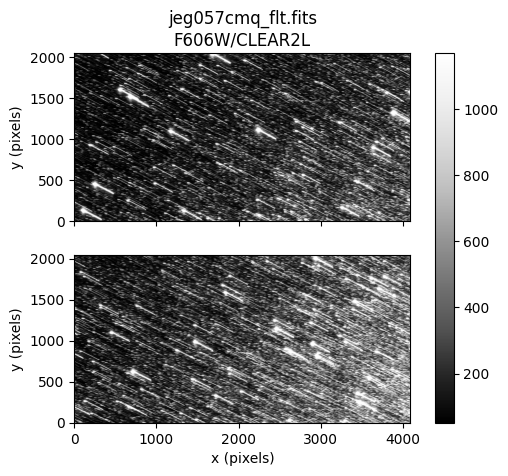

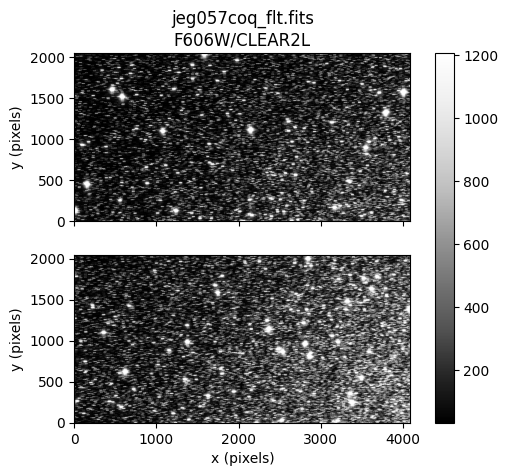

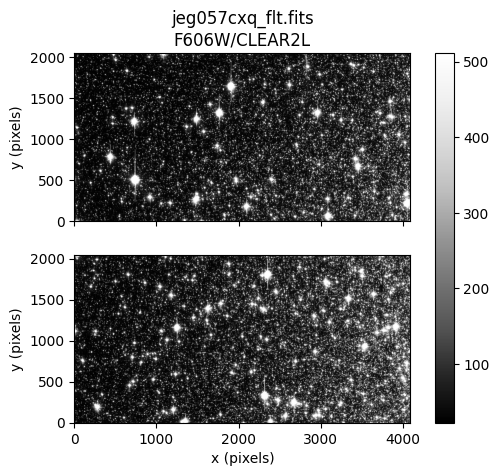

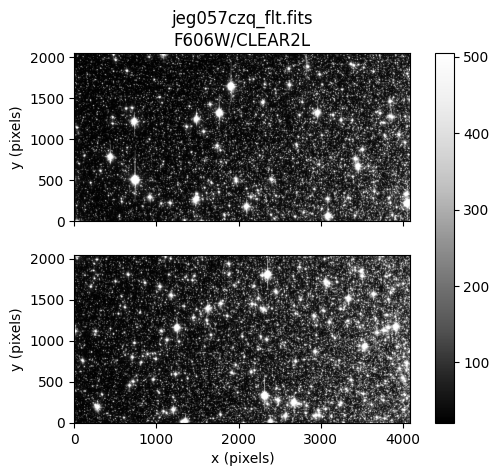

In [5]:
for flt in flt_files:

    hdu = fits.open(flt)
    hdr = hdu[0].header

    # Only 1 SCI extension for SBC images
    if hdr['DETECTOR'] == 'SBC':
        sci1 = hdu[1].data
            
        filter1 = hdr['FILTER1']

        norm = simple_norm(sci1, 'linear', percent=90)
        
        fig, ax0 = plt.subplots(1, 1)

        im = ax0.imshow(sci1, origin='lower', norm=norm, cmap='Greys_r')

        ax0.set_xlabel('x (pixels)')
        ax0.set_ylabel('y (pixels)')
        ax0.set_title(f'{flt.split("/")[-1]}\n{filter1}')
        fig.colorbar(im, ax=ax0)

    # 2 SCI extensions for WFC images
    elif hdr['DETECTOR'] == 'WFC':
        sci1 = hdu[4].data
        sci2 = hdu[1].data
        
        filter1 = hdr['FILTER1']
        filter2 = hdr['FILTER2']
        
        norm = simple_norm(sci1, 'linear', percent=90)

        fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)

        im = ax0.imshow(sci1, origin='lower', norm=norm, cmap='Greys_r')
        ax1.imshow(sci2, origin='lower', norm=norm, cmap='Greys_r')

        ax1.set_xlabel('x (pixels)')
        ax0.set_ylabel('y (pixels)')
        ax1.set_ylabel('y (pixels)')
        ax0.set_title(f'{flt.split("/")[-1]}\n{filter1}/{filter2}')
        fig.colorbar(im, ax=(ax0, ax1))

In this example, the third and fourth images, `jeg057cmq` and `jeg057coq`, consist of streaked stars. This is a very clear example of a guiding failure. The other images appear normal with many bright point-like stars in the field of view.

Often, the shutter will close if a guiding failure occurs. These images will not be blank, but will contain normal detector features such as cosmic rays and hot pixels.

<a id="inspect"></a>
## 2. Inspect JIF header keywords 

To further investigate any guiding issues in the dataset, we inspect certain header keywords in the [observing log (JIF) files](https://www.stsci.edu/hst/instrumentation/focus-and-pointing/pointing/jitter-file-format-definition). There are two JIF files, one for each association, each listing observing information for two exposures. There is a section in the zeroth extension of the JIF files that lists problem flags for the dataset, which we print and inspect first.

In [6]:
# Define color strings and expected JIF keyword values
colorstr_WARNING = '\033[91m' # red
colorstr_RESET = '\033[0m' # reset

jif_header_keys = {'T_GDACT': {'expected': True},
                   'T_ACTGSP': {'expected': True},
                   'T_GSFAIL': {'expected': False},
                   'T_SGSTAR': {'expected': False},
                   'T_TLMPRB': {'expected': False},
                   'T_NOTLM': {'expected': False},
                   'T_NTMGAP': {'expected': 0},
                   'T_TMGAP': {'expected': 0},
                   'T_GSGAP': {'expected': False},
                   'T_SLEWNG': {'expected': False},
                   'T_TDFDWN': {'expected': False}}

jif_list = sorted(glob.glob(f'p{program_id}/*jif.fits'))

for jif in jif_list:
    
    with fits.open(jif) as hdu:
        jif_hdr = hdu[0].header

    print(jif.split('/')[-1])

    # print section of JIF header with problem flags
    for i in range(-18, -7):
        key = list(jif_hdr.keys())[i]
        
        # Highlight unexpected values in red
        if jif_hdr[key] != jif_header_keys[key]['expected']:
            print(colorstr_WARNING + repr(jif_hdr[i:i+1]) + colorstr_RESET)        
        else:
            print(repr(jif_hdr[i:i+1]))
    print('\n')

jeg057011_jif.fits
T_GDACT =                    T / Actual guiding mode same for all exposures     
T_ACTGSP=                    T / Actual Guide Star Separation same in all exps. 
T_GSFAIL=                    F / Guide star acquisition failure in any exposure 
T_SGSTAR=                    F / Failed to single star fine lock                
T_TLMPRB=                    F / problem with the engineering telemetry in any e
T_NOTLM =                    F / no engineering telemetry available in all exps.
T_NTMGAP=                    0 / total number of telemetry gaps in association  
T_TMGAP =             0.000000 / total duration of missing telemetry in asn. (s)
T_GSGAP =                    F / missing telemetry during GS acq. in any exp.   
T_SLEWNG=                    F / Slewing occurred during observations           
T_TDFDWN=                    F / Take Data Flag NOT on throughout observations  


jeg057021_jif.fits
T_GDACT =                    T / Actual guiding mode same for all exp

The only problem flag in these JIF files is that `T_TDFDWN` is True in the second file, which is highlighted in red to show it is different than the expected value (False). This means that the Take Data Flag was down at some point during the third and fourth exposures. If the Take Data Flag is up, that means an observation can proceed. If it goes down, the observation may stop, shutters may close, and generally, no more science data is taken until the flag goes back up. Interestingly, the shutter clearly opened during the third and fourth exposures shown in the figures above.

We may expect `T_GSFAIL` to be True in the second JIF file, since the TDF went down, but it is False, suggesting that the guiding problem that led to streaked images likely happened before the exposures began.

Next, we look at the header keywords in the first and subsequent extensions of the JIF file to learn more about observing problems in the individual exposures.

In [7]:
def further_ext(jif_file):

    numexts = fits.getheader(jif_file, 0)['NEXTEND'] # number of extensions i.e. exposures

    keywords = ['EXPNAME*', 'GUIDEACT*', 'GSACQ*', 'ACTGSSEP*',
                'GSSEPRMS*', ' NLOSSES*',
                'V2_RMS*', 'V3_RMS*', 'GSFAIL*', 'TDF-DOWN*']

    for ext in range(1, numexts+1):
        print("JIF Header Ext Number:", ext)
        print('-'*80)
        header = fits.getheader(jif_file, ext)
        for keyword in keywords:
            # try to display keyword because it may not be present 
            details = header[keyword]
            if details is not None:
                print(repr(details))
            else:
                print(f'Keyword {keyword} not found in extension {ext}')
        print('\n')

In [8]:
for jif in jif_list:

    further_ext(jif)

JIF Header Ext Number: 1
--------------------------------------------------------------------------------
EXPNAME = 'jeg057chj                ' / exposure identifier                     
GUIDEACT= 'FINE LOCK           ' / Actual Guiding mode at end of GS acquisition 
GSACQ   = '2021.201:11:20:29   ' / Actual time of GS Acquisition Completion     
ACTGSSEP=             1092.737 / Actual Guide Star Separation (arcsec)          
GSSEPRMS=                  0.6 / RMS of Guide Star Separation (milli-arcsec)    

V2_RMS  =                  1.8 / dominant guide star V2 axis RMS (mas)          
V3_RMS  =                  1.4 / dominant guide star V3 axis RMS (mas)          




JIF Header Ext Number: 2
--------------------------------------------------------------------------------
EXPNAME = 'jeg057cjj                ' / exposure identifier                     
GUIDEACT= 'FINE LOCK           ' / Actual Guiding mode at end of GS acquisition 
GSACQ   = '2021.201:11:20:29   ' / Actual time of GS A

Keywords from the JIF files indicate that the third and fourth exposures were taken without a lock on guide stars. The actual guiding mode, `GUIDEACT`, was `GYRO`, meaning the guiding was controlled by the telescope gyro alone, which explains the detector motion. The guide star keywords `ACTGSSEP`, `GSSEPRMS`, `V2_RMS` and `V3_RMS` are set to the nonphysical value `-32767`, and `TDF-DOWN` is True. 

The other exposures had two guide stars acquired, as indicated by `GUIDEACT = FINE LOCK`. (When a single guide star is acquired, `GUIDEACT` is set to `FINE/GYRO`.) The guide star keywords `ACTGSSEP`, `GSSEPRMS`, `V2_RMS`, and `V3_RMS` are set to realistic, typical values.

<a id="jitter"></a>
## 3. Check jitter 

Sometimes the telescope may shake or move slightly during an observation, while guiding in `FINE LOCK`. This is called jitter. Motion of the detector in the V2, V3 coordinate system is saved in the jitter (JIT) file, and can be inspected for any extreme excursions that could affect data quality.

In [9]:
def jitter_plots(jit_file):
    
    numexts = fits.getheader(jit_file, 0)['NEXTEND'] 

    for ext in range(1, numexts+1):

        jit_data = fits.getdata(jit_file, ext)
        expname = fits.getheader(jit_file, ext)['EXPNAME']
        
        plt.figure()
        plt.grid(alpha=0.5)
        plt.scatter(jit_data['Seconds'], jit_data['SI_V2_AVG'], 15, 
                    alpha=0.5, marker='o', label='V2_AVG')
        plt.scatter(jit_data['Seconds'], jit_data['SI_V3_AVG'], 15, 
                    alpha=0.5, marker='o', label='V3_AVG')
        plt.scatter(jit_data['Seconds'], jit_data['SI_V2_RMS'], 10, 
                    alpha=0.5, marker='s', label='V2_RMS')
        plt.scatter(jit_data['Seconds'], jit_data['SI_V3_RMS'], 10, 
                    alpha=0.5, marker='s', label='V3_RMS')
        
        plt.xlabel('Exposure Time [Seconds]', size=13)
        plt.ylabel('Coordinate Axis [Arcsec]', size=13)
        plt.title(f"Jitter File Ext Number: {ext}\n Exposure: {expname}", size=14)
        plt.legend(ncol=2)
        plt.minorticks_on()

In [10]:
jit_list = sorted(glob.glob(f'p{program_id}/*jit.fits'))

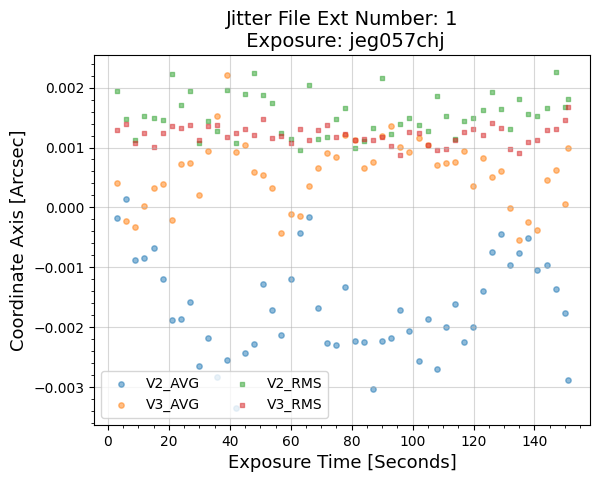

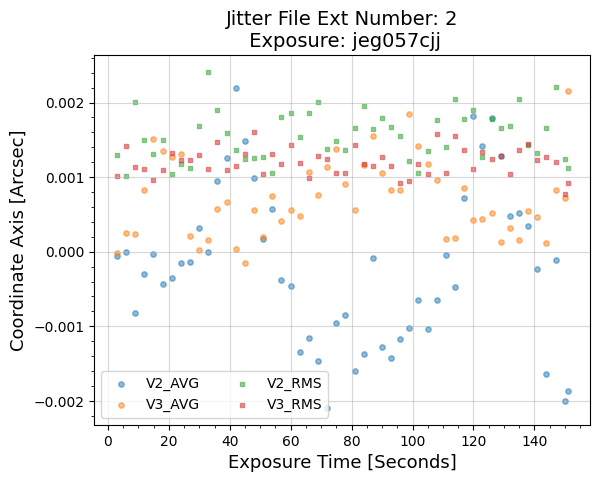

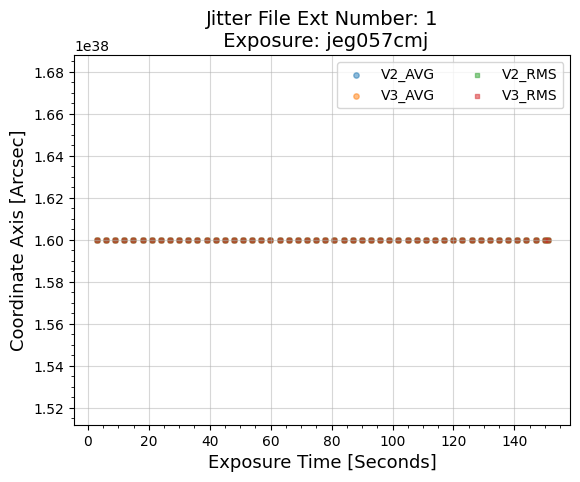

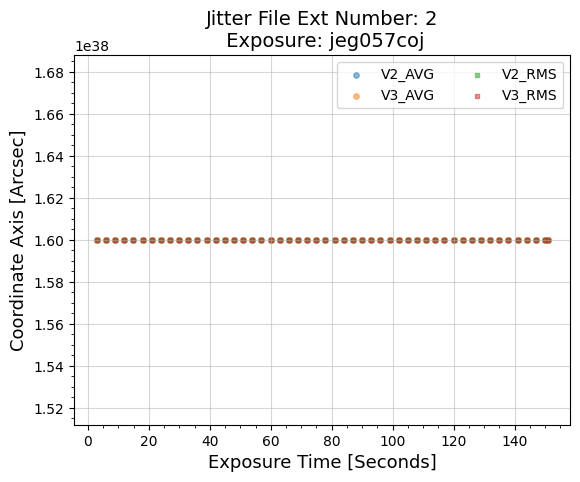

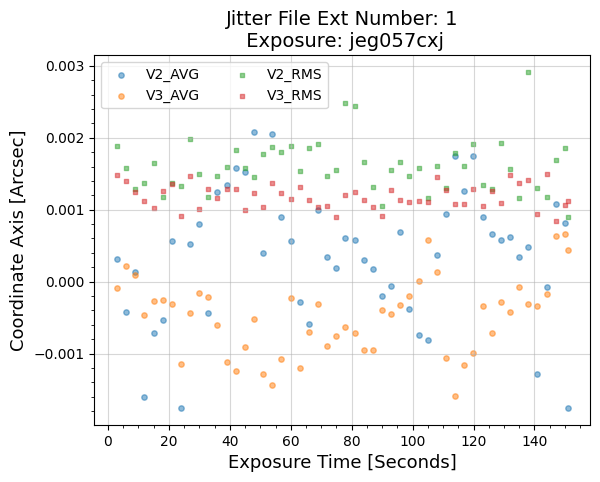

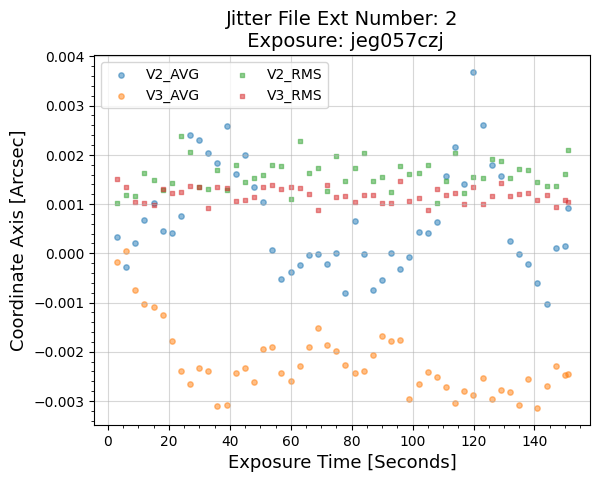

In [11]:
for jit in jit_list:
    
    jitter_plots(jit)

The third and fourth exposures have jitter values pegged at a nonphysical value of 1.6e38, which is simply a placeholder for observations in which the guide stars were not acquired. The remaining exposures show a very minor amount of telescope motion, typically <3 mas, and the jitter RMS is typically <2 mas.

This further confirms there were no guide stars acquired for the third and fourth images, but the remaining images were not affected by guide star problems. The above analysis is enough to determine that a HOPR is warranted for the two images for which the telescope was guiding in GYRO mode.

If data quality is still unclear at this point, proceeding to the next section may be useful. Another avenue for futher analysis that we recommend, radial profile fitting of stars, is thoroughly covered in Step 6 in the [WFC3 Exception Report Checklist notebook](https://spacetelescope.github.io/hst_notebooks/notebooks/WFC3/exception_report/wfc3_exception_report.html#further-analysis).

<a id="hst1pass"></a>
## (Optional) 4. Check PSF quality with hst1pass 

If your images have at least a handful of unsaturated stars, running the PSF-fitting photometry package [hst1pass](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2202.pdf) on your data can provide an independent check of PSF quality, and may help you decide if a HOPR is warranted.

### 4.1 Environment Setup

We first install Fortran by typing `conda install -c conda-forge gfortran` in the terminal. You may need to save and close this notebook, install Fortran, and then restart this notebook to ensure Fortran is active in your environment.

Next, we download the hst1pass Fortran package from [https://www.stsci.edu/~jayander/HST1PASS/CODE/hst1pass/](https://www.stsci.edu/~jayander/HST1PASS/CODE/hst1pass/) and compile it. Alternatively, this can be done manually by downloading the latest file from the website directly, and compiling it on the command line with the command `gfortran hst1pass.2025.02.14_v1h.F`. This is the most recent version of the Fortran package as of the writing of this notebook, so it would be prudent to check for a newer version on the website above.

In [12]:
file = 'hst1pass.2025.02.14_v1h.F'
file_url = f'https://www.stsci.edu/~jayander/HST1PASS/CODE/hst1pass/{file}'

# Download the fortran file if it doesn't exist
if not os.path.exists(f'./{file}'):
    print('Downloading:', file_url)
    urllib.request.urlretrieve(file_url, f'./{file}')

# Compile hst1pass if it hasn't been yet
if not os.path.exists('./hst1pass.e'):
    subprocess.run(["gfortran", file, "-o", "hst1pass.e"], check=True)
    print('The executable hst1pass.e has been compiled')
else:
    print('The executable hst1pass.e already exists')

The executable hst1pass.e already exists


Next, we download the [standard library PSF](https://www.stsci.edu/~jayander/HST1PASS/LIB/PSFs/STDPSFs/) for the filter used for your data. See the figure titles in step 3 above for filter information: ACS/WFC F606W in this example. Note that PSFs are not available for all ACS filters, so that may limit your ability to complete this step.

In [13]:
psf_name = 'STDPSF_ACSWFC_F606W_SM4.fits'
psf_url = f'https://www.stsci.edu/~jayander/HST1PASS/LIB/PSFs/STDPSFs/ACSWFC/{psf_name}'

# Download the PSF file if it doesn't exist.
if not os.path.exists(f'./{psf_name}'):
    print('Downloading:', psf_url)
    urllib.request.urlretrieve(psf_url, f'./{psf_name}')

### 4.2 Run hst1pass

Here we run hst1pass on the FLT files with a simple set of input parameters:
- `HMIN = 5` requires that a given pixel have no brighter pixels within 5 pixels radius
- `FMIN = 150` requires that source contain at least 150 electrons in a 2x2 pixel box
- `PSF` lists the PSF file
- `PERT = 1` allows the library PSF to be perturbed to find the single best PSF for a given image
- `OUT = xymeq` specifies the output quantities: detector coordinates `x` and `y`, instrumental magnitude and error `m` and `e`, and the quality of fit metric for the PSF fit `q`.

In [14]:
for flt in flt_files:
    cmd_list = ["./hst1pass.e", "HMIN=5", "FMIN=150", "PSF=STDPSF_ACSWFC_F606W_SM4.fits", "PERT=1", "OUT=xymeq", flt]
    subprocess.run(cmd_list, check=True)

            
------------------------------------------------
            
ARG0000: ./hst1pass.e                                                                    
ARG0001: HMIN=5                                                                          
ARG0002: FMIN=150                                                                        
ARG0003: PSF=STDPSF_ACSWFC_F606W_SM4.fits                                                
ARG0004: PERT=1                                                                          
ARG0005: OUT=xymeq                                                                       
ARG0006: p16380/jeg057chq_flt.fits                                                       
            
----------------------------------------------
            
OUTPUT FROM PROGRAM hst1pass: ./hst1pass.e                                                                    
            
     HMIN:        5
     FMIN:      150.0
 PSFFILEI:     STDPSF_ACSWFC_F606W_SM4.fits             

                  
             STEMu   : jeg057chq
             FILTu   : F606W
             PROPu   : 16380
             RDATu   :  2021.55199
                   
             INSTRUME: 'ACS   '            
             DETECTOR: 'WFC'               



             FLASHSTA: 'NOT PERFORMED   '  
             FLSHCORR: 'OMIT    '          
             SHUTRPOS:    A
             FLASHCUR:    O
             FLASHDUR:    0.0
             FLASHLVL:    0.0
             DARKTIME:  153.2
             DARKEST :    1.8
                       
             PSFFILE : STDPSF_ACSWFC_F606W_SM4.fits                                                                       
             GDCFILE : NONE                                                                                               
                        
             DOSATD  :      T
             HIFLAG  :  76000
             
             IDENTIFY SATURATED STARS 
 CALL peak_sat_NAXIS       76000


 LLAC peak_sat_NAXIS       76000
              
             GET FLUXES FOR SATURATED STARS 
              
                 PSFFILE_USE: STDPSF_ACSWFC_F606W_SM4.fits                                                                       
              



                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                00001 2771 0013 -13.96   27.9     384660.8      1     25 0.9087
                00002 0480 0017 -13.59   23.2     271994.2      1     25 0.8973
                00003 2442 0019 -14.09   33.5     432198.4      1     25 0.9096
                00004 3737 0021 -16.58   47.4    4301783.5     40    159 0.9992
                00005 0065 0025 -14.50   40.9     632282.8      1     25 0.8994
                00006 0835 0028 -14.31   25.5     529644.9      2     25 0.9019
                00007 3238 0028 -16.16   54.5    2901524.5     27    115 0.9916
                00008 3877 0029 -14.72   39.6     771839.8      3     41 0.9501
                00009 3987 0034 -14.30   40.2     525028.4      1     30 0.9170
                00010 3558 0038 -18.80 

                00013 0251 0053 -18.84  173.4   34387348.0    317    787 1.0196
                00020 2000 0089 -14.04   28.5     414735.2      1     25 0.9094


                00030 0015 0143 -14.89   30.0     902924.8      4     35 0.9158
                00040 3729 0241 -13.74   39.4     313680.2      0     25 0.9081


                00050 2547 0294 -13.84   31.4     345066.2      0     25 0.9110
                00057 3496 0313 -19.32  240.0   53413100.0    547   1499 1.0190
                00060 3628 0322 -14.28   53.0     516234.3      1     30 0.9253


                00070 1749 0376 -13.91   24.5     364757.8      1     25 0.9101
                00080 3765 0408 -14.67   53.3     736749.1      3     40 0.9427


                00090 3603 0454 -16.09   48.3    2739944.5     24    109 0.9928
                00100 2279 0483 -16.25   36.5    3154168.0     29    121 0.9934


                00114 2794 0534 -20.56  552.6  166840240.0   1699   4450 1.0256


                00200 2368 0945 -14.12   34.3     444582.5      1     25 0.9114


                00300 1629 1714 -17.36   56.2    8810559.0     81    253 1.0050


                00396 1482 2335 -21.26  766.7  318206624.0   2929   6517 1.0344
                00400 2893 2367 -14.08   32.5     428538.4      1     25 0.9117


                00500 0539 3127 -15.76   28.0    2013370.0     16     75 0.9775


                00600 2311 3988 -14.65   27.7     726905.7      3     35 0.9313
                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------

                MEASURED SATd STARS:  606   BRIGHTEST: L0396 1482 2335  -21.26


                       
             HISTMODE:    26.53
                        
             PSFFILE_INP: STDPSF_ACSWFC_F606W_SM4.fits                                                    
             PSFFILE_PRT: jeg057chq_psf.fits                                                              
                        
             CALL FIND_PSFPERT -- 1x1


                       
             CENPERT :        1
                         1   0.0057

             NOW, GO THROUGH IMAGE AND FIND STARS

                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                        1   232.373     5.959  -8.649   92.9|5  4  7|    662|   559   203   242   169|   178   168   554   116|     92    1295    1295
                        2  1498.119     6.462 -12.916   33.1|5 11 14|  25119| 12834  7221 24396  4880| 10967  7552  4167  2560|     33   52072   52072


                       24   773.607     7.910 -12.939   24.9|5 11 14|  26952|  7431 22584  9105 12028|  3976  7560  7263  9227|     24   50034   50034
                       26  1418.179     8.179 -13.191   31.2|5 11 14|  39869| 20767 10043 20285  9870| 11434  6603  7767  4081|     31   64987   64987
                       85  2771.134    12.741 -13.963   42.0|9  0  0| 384660| 38398 21309 22479 49597| 14865  8321 27500 13910|     41  500050  500050
                      142  2442.062    19.262 -14.089   52.5|9  0  0| 432198| 40098 30373 64384 25401| 25115 18930 15535  9747|     52  561690  561690


                      168  3736.694    20.902 -16.584  228.3|9  0  0|4301783| 84776 84051 82731 82837| 82790 83054 83088 83029|    228 4552378 4552378


                      333  3557.848    37.596 -18.797  872.3|9  0  0|*******| 87021 84888 86407 86693| 87692 85098 87649 85433|    872 ******* *******


                      478   250.622    54.106 -18.841  853.5|9  0  0|*******| 98744 96486 98377 97860| 97002 96817 97392 96998|    853 ******* *******


                      778   114.077    80.891 -12.320   45.4|5 10 13|  17867|  7416  5644  5334  7414|  3870  2557  5382  2712|     45   24657   24657


                     1000  1876.621   101.627  -7.263   27.6|5  4  7|    174|    44   137    50   132|    54    60    81    98|     27     330     330


                     1639   279.675   162.526  -6.948   23.1|5  4  7|    105|    57    75   100    27|    49    95    50    66|     23     206     206


                     2000  3135.577   195.091  -7.517   40.1|5  3  6|    239|    83   207   124   101|    59   110    71    91|     40     383     383


                     2489   541.208   243.101  -6.717   32.0|5  3  6|    131|    89    72    85    52|    59    27    61    59|     31     174     174


                     3000  3573.777   288.985  -7.771   58.1|5  3  6|    372|   137   225   145   166|   104   114    93   103|     58     479     479


                     3246  3495.678   313.060 -19.319  858.3|9  0  0|*******| 83362 82415 83519 83885| 83210 82207 82794 82832|    858 ******* *******


                     3343    20.080   323.814  -8.585   17.4|5  5  8|    514|   241   190   170   306|   130    80   185    91|     17     790     790


                     4000  1097.479   390.346 -11.528   25.1|5  9 12|   6622|  6374   967  4785  1407|  4349   787  1390   463|     25   16919   16919


                     4152   424.009   404.767  -8.907   34.8|5  6  9|    782|   299   296   215   427|   152   120   287   176|     34    1120    1120


                     4977   194.681   485.929  -6.936   22.9|5  3  6|    140|    67    97    55    68|    31    51    54    54|     22     179     179
                     5000  2022.825   488.895 -14.566  521.2|9  0  0| 670507| 40053 67037 76859 67909| 26099 38355 23435 18671|    521  852652  852652


                     5445  2794.000   534.000 -20.556    0.0|9  0  0|*******| 90010 84411 87935 87937| 88348 84437 88507 84240|      0 ******* *******


                     5754  1567.314   567.102 -10.728   46.8|5  7 10|   4641|  2829   676  1805  1112|  1228   436  1000   379|     46    7721    7721


                     6000  3578.463   591.180  -7.590   45.5|5  3  6|    223|   213    68   147    97|   136    74   114    80|     45     371     371


                     6591  1000.418   647.590  -9.165   27.6|5  4  7|    878|   581   137   119   653|   116    66   596    94|     27    2035    2035


                     7000  1378.187   687.118  -8.255   18.2|5  5  8|    473|   236   116   206   133|   124    68   105    59|     18     659     659


                     7430   158.429   728.697  -6.573   22.3|5  3  6|     97|    78    39    40    63|    37    24    69    28|     22     157     157


                     8000  3894.555   781.874 -12.748   49.2|5  9 12|  22683|  5808 21154  7367 10793|  3124  6639  4615  9290|     49   47127   47127


                     8249   370.270   809.654  -9.282   26.4|5  7 10|    997|   611   194   258   719|   204   108   507   174|     26    2061    2061


                     9000  3163.455   884.903  -7.802   28.7|5  5  8|    293|   275    83    96   136|   108    51   124    42|     28     550     550
                     9049   725.584   891.333 -10.654   30.0|5  8 11|   3408|   967  2647  2119   733|   678  1911   569   529|     29    7784    7784


                     9834   488.949   971.645  -8.229   20.0|5  5  8|    408|   160   164   116   306|    58    58   125   131|     19     677     677
                    10000  1880.297   989.281  -8.227   24.1|5  5  8|    430|   263    93   239    97|   173    76    94    58|     24     727     727


                    10610   842.264  1053.010 -11.208   24.5|5  9 12|   7498|  3908  1109  2190  2252|  1544   596  1589   606|     24   10870   10870


                    11000  3409.608  1094.597 -10.115   52.6|5  6  9|   1823|   488  1416   583  1577|   278   487   494  1192|     52    4375    4375


                    11378   221.774  1134.173  -7.895   30.4|5  4  7|    331|   109   192   171    92|    87   112   105    77|     30     510     510


                    12000   619.486  1202.143  -9.132   21.1|5  6  9|   1198|   678   342   170   105|   358    70   149    31|     21    1649    1649


                    12126   334.871  1214.703  -8.018   19.4|5  5  8|    358|   105   156    88   252|    52    85    83   103|     19     608     608


                    12852   536.865  1296.084 -12.480   23.2|5 11 14|  23971|  6956 10214  8532  6235|  3662  4383  4244  2983|     23   34500   34500
                    13000  1386.824  1312.296 -13.115   35.6|5 11 14|  36835| 11564 17657 22031  7671|  7716 12230  6603  4381|     35   66654   66654


                    13564   229.005  1377.362  -9.942   21.6|5  8 11|   2032|   780   629  1324   323|   559   497   316   205|     21    3194    3194


                    14000  3423.373  1427.084  -9.471   41.6|5  6  9|   1294|   946   232   577   416|   445   162   380   148|     41    2240    2240


                    14294   120.284  1457.770 -11.689   22.8|5 10 13|   9098|  5588  1883  2190  5102|  1809   704  3763  1096|     22   16918   16918


                    15000  2873.117  1537.119  -8.836   28.0|5  6  9|    857|   340   181   367   289|   195   149   167   109|     28    1123    1123
                    15008   970.736  1539.096  -8.115   21.1|5  5  8|    366|   132   221   161   139|    76   136   112    86|     21     558     558


                    15750   751.372  1620.465  -9.229   23.4|5  7 10|    780|   591   137   686   138|   500   163   160    77|     23    1809    1809


                    16000  1304.850  1643.793  -8.352   31.1|5  5  8|    427|   170   233   150   271|   106   117   147   158|     31     668     668


                    16465   688.596  1701.366  -7.845   23.0|5  4  7|    238|    91   197   210    75|    79   129    73    73|     23     497     497


                    17000  3050.699  1763.620  -8.127   28.6|5  5  8|    320|    98   231   147   271|    70   104   118   220|     28     716     716
                    17140   111.301  1781.610 -12.495   24.2|5 11 14|  16885| 10161  3518  3567 13195|  3263  1141  9188  2673|     24   35784   35784


                    17862    83.912  1862.930 -11.432   19.6|5 10 13|   7921|  2638  3451  2283  3490|  1390  1229  1835  1368|     19   11409   11409


                    18000  3919.443  1879.404 -10.017   26.9|5  6  9|   1682|  1439   274  1254   299|  1099   257   360   115|     26    4028    4028


                    18522   457.785  1943.610  -7.551   24.3|5  4  7|    176|    81   116    89   174|    68    80    64    98|     24     326     326


                    19000   184.012  2002.166  -7.311   20.9|5  4  7|    219|    74    73   107    82|    72    40    45    36|     20     257     257


                    19189   198.036  2025.331  -9.723   22.4|5  7 10|   1999|    51  1492   478   397|    36   971    21   121|     22    4023    4023


                    19754   628.935  2105.581 -12.494   35.6|5 10 13|  19317|  6407  7764  3629 13794|  2395  1718  6575  5779|     35   34027   34027


                    20000   854.084  2135.274  -9.927   31.9|5  7 10|   1728|   780   501  1335   478|   540   456   423   287|     31    2898    2898


                    20413   131.214  2186.466  -7.206   22.9|5  4  7|    128|    75    50    45   124|    53    32    88    50|     22     186     186


                    21000  2745.119  2259.515 -10.476   28.6|5  8 11|   3330|  1269   733   542  2579|   336   213  1234   702|     28    6208    6208
                    21051   696.022  2268.300  -8.623   48.4|5  5  8|    747|   202   139   418   191|   219   145   120   130|     48    1063    1063


                    21591  1482.000  2335.000 -21.257    0.0|9  0  0|*******|102175103010103484104031|103440101220103798101909|      0 ******* *******
                    21711   364.188  2348.821  -8.455   28.2|5  5  8|    450|   223   129   162   243|   125    77   179    89|     28     581     581


                    22000  2347.759  2391.142  -9.142   19.9|5  6  9|    888|   282   488   480   305|   168   355   196   179|     19    1561    1561


                    22299   358.696  2430.006 -11.326   23.4|5 10 13|   6714|  2101  4413  2608  2243|  1072  1932  1662  1475|     23   11456   11456


                    22888  1575.411  2510.366  -7.351   41.4|5  4  7|    163|   120    43    67   162|    74    53   145    60|     41     309     309
                    23000  2340.813  2524.620  -8.680   50.3|5  4  7|    562|   193   315   196   445|   141   116   189   264|     50     998     998


                    23519   447.103  2591.683 -10.891   18.5|5  9 12|   4918|  1854  1315   930  2691|   592   431  1655   765|     18    7651    7651


                    24000  3163.247  2656.124 -10.584   44.9|5  7 10|   3793|  2057   707  1819   965|  1075   440   904   433|     44    6329    6329


                    24135    87.517  2673.250  -9.980   20.0|5  8 11|   1471|   514  1412   991   450|   269  1056   408   418|     19    3720    3720


                    24785   253.449  2753.866 -11.803   49.9|5 10 13|   9323|  7602  1319  2666  3545|  2510   536  3872   932|     49   16361   16361


                    25000  3890.076  2778.883 -11.240   41.1|5  6  9|   7132|  2841  1947  2266  2911|  1261   860  1855  1054|     41    9841    9841


                    25418   422.987  2835.340  -8.025   24.1|5  4  7|    298|   136   124   240   106|   116   109   101    67|     24     476     476


                    26000   864.421  2910.720  -7.809   27.1|5  5  8|    264|   206    55    82   152|    86    28   138    54|     27     464     464
                    26039   315.673  2916.145 -12.128   23.7|5 11 14|  13212|  4189  9216  6360  3875|  2375  5134  3380  2575|     23   25570   25570


                    26598   107.359  2996.970  -7.193   22.6|5  4  7|    148|   114    39    91    72|    47    31    65    39|     22     213     213


                    27000  3458.323  3047.725  -9.391   44.5|5  6  9|   1199|   828   222   310   672|   249   129   512   202|     44    2272    2272


                    27203   346.269  3077.823 -10.902   31.3|5  9 12|   4608|  2712   898  1159  2045|   884   345  1519   549|     31    7276    7276


                    27801    36.703  3159.055  -9.132   24.7|5  6  9|    815|   300   532   407   308|   153   280   249   217|     24    1390    1390


                    28000  3464.313  3183.922  -8.550   92.5|5  4  7|    596|   408   178   282   312|   237   139   278   168|     92     805     805


                    28416  1230.027  3240.095 -12.363   46.5|5 10 13|  19100|  7412  5859  8563  5280|  3890  3208  4515  2575|     46   25630   25630


                    29000  2395.364  3317.066 -11.905   27.7|5 10 13|  11852|  8624  1786  4980  3345|  3729  1012  3374  1200|     27   21575   21575
                    29025  2668.436  3320.866  -9.361   25.5|5  7 10|   1128|   961   153   309   448|   292    97   427   151|     25    2084    2084


                    29621   747.401  3402.398 -10.689   22.2|5  8 11|   2877|  2372   425  2569   657|  1870   402   713   270|     22    7235    7235


                    30000  3741.881  3453.223 -16.094  151.8|9  0  0|2739832| 86465 85248 89425 89140| 84754 85698 85170 78189|    151 3000502 3000502


                    30206   563.928  3483.317  -6.897   42.0|5  3  6|    158|    87    75   115    62|    77    81    75    73|     42     185     185


                    30788  3281.273  3564.374  -8.296   31.6|5  5  8|    389|   275   121   339   110|   211    94   109    77|     31     822     822


                    31000  3216.407  3593.990  -9.946   30.8|5  6  9|   1742|  1508   375   722   629|   633   170   692   222|     30    3153    3153


                    31374   582.046  3645.130  -7.365   21.9|5  4  7|    193|   103    74   102    73|    62    70    73    53|     21     234     234


                    31971    30.692  3725.878  -7.911   20.8|5  5  8|    265|   112   202   101   158|    51    87    77    93|     20     430     430
                    32000  2125.945  3729.817  -6.765   23.7|5  3  6|    146|    51    73    44    70|    36    33    50    27|     23     154     154


                    32546   358.342  3806.762  -7.245   38.7|5  4  7|    204|   138    54    62   100|    63    41   103    74|     38     294     294


                    33000  3265.012  3870.850  -7.558   25.8|5  4  7|    295|    98    90    83   125|    64    53    88    66|     25     348     348
                    33105   533.962  3888.149  -8.831   24.4|5  5  8|    571|   220   219   373   205|   152   167   200    97|     24     864     864


                    33649  1379.837  3968.730 -11.381   26.4|5  9 12|   7221|  2121  3581  1498  4261|   911   940  2131  1950|     26   12344   12344


                    34000  1802.632  4021.958  -8.929   15.6|5  6  9|   1417|   144   580   230   338|    49   135    71   207|     15    2170    2170


                    34191  1199.807  4049.917  -8.858   26.2|5  6  9|    637|   219   414   213   340|   170   138   180   173|     26    1038    1038


                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------

             -----------------------------------------
             FINDING STATISTICS
             -----------------------------------------
              Y     NPIX     %PIX    EXPLANATION
              1    28602    0.170%   ..1..not on chip....
              2 15256743   90.937%   ..2..not loc max....
              3  1263856    7.533%   ..3..h < hmax.......
              4    94526    0.563%   ..4..flux too low...
              5        0    0.000%   ..5..below mask thr.
              6        0    0.000%   ..6..out of bounds..
    

  
 --------------
 FIND SPACING: 
 --------------
     F01 (06:14)     u -- u ref-frame       
     F02 (06:14)     v -- v ref-frame       
     F03 (02:08)     M -- instl mag (1000s) 
     F04 (03:11)     x -- raw detector x pos
     F05 (03:11)     y -- raw detector y pos
     F06 (02:08)     m -- instl mag         
     F07 (02:02)     k -- detector chip no  
     F08 (03:11)     X -- dist-cor x posn   
     F09 (03:11)     Y -- dist-cor y posn   
     F10 (01:02)     h -- local isolation   
     F11 (04:08)     H -- list-based isolatn
     F12 (05:16)     r -- RA (deg)          
     F13 (05:16)     d -- Dec (deg)         
     F14 (05:16)     R -- RA (deg; adjustd) 
     F15 (05:16)     D -- Dec (deg; adjustd)
     F16 (03:06)     i -- peak pixel column 
     F17 (03:06)     j -- peak pixel row    
     F18 (04:12)     p -- peak pixel value  
     F19 (06:12)     q -- quality of fit    
     F20 (07:12)     c -- chisq of fit      
     F21 (05:14)     U -- u ref-frame (corr)
    

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_DENORMAL


            
------------------------------------------------
            
ARG0000: ./hst1pass.e                                                                    
ARG0001: HMIN=5                                                                          
ARG0002: FMIN=150                                                                        
ARG0003: PSF=STDPSF_ACSWFC_F606W_SM4.fits                                                
ARG0004: PERT=1                                                                          
ARG0005: OUT=xymeq                                                                       
ARG0006: p16380/jeg057cjq_flt.fits                                                       
            
----------------------------------------------
            
OUTPUT FROM PROGRAM hst1pass: ./hst1pass.e                                                                    
            
     HMIN:        5
     FMIN:      150.0
 PSFFILEI:     STDPSF_ACSWFC_F606W_SM4.fits             

                  
             STEMu   : jeg057cjq
             FILTu   : F606W
             PROPu   : 16380
             RDATu   :  2021.55201
                   
             INSTRUME: 'ACS   '            
             DETECTOR: 'WFC'               



             FLASHSTA: 'NOT PERFORMED   '  
             FLSHCORR: 'OMIT    '          
             SHUTRPOS:    B
             FLASHCUR:    O
             FLASHDUR:    0.0
             FLASHLVL:    0.0
             DARKTIME:  153.2
             DARKEST :    1.8
                       
             PSFFILE : STDPSF_ACSWFC_F606W_SM4.fits                                                                       
             GDCFILE : NONE                                                                                               
                        
             DOSATD  :      T
             HIFLAG  :  76000
             
             IDENTIFY SATURATED STARS 
 CALL peak_sat_NAXIS       76000


 LLAC peak_sat_NAXIS       76000
              
             GET FLUXES FOR SATURATED STARS 
              
                 PSFFILE_USE: STDPSF_ACSWFC_F606W_SM4.fits                                                                       
              



                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                00001 2771 0013 -13.97   26.2     386213.2      1     25 0.9087
                00002 2442 0019 -14.09   31.8     432900.7      1     25 0.9096
                00003 3737 0021 -16.58   45.7    4298325.0     40    154 0.9943
                00004 0065 0025 -14.51   39.2     637780.4      1     25 0.8994
                00005 0835 0028 -14.32   24.5     532823.2      2     30 0.9096
                00006 3238 0028 -16.16   51.8    2903898.5     27    115 0.9916
                00007 3877 0029 -14.72   38.2     770076.1      3     40 0.9490
                00008 3987 0034 -14.30   38.1     526871.3      1     30 0.9170
                00009 3558 0038 -18.80  160.9   33030586.0    340    836 1.0184
                00010 3366 0040 -14.17 

                00013 0251 0053 -18.84  173.3   34426968.0    318    778 1.0167
                00020 0187 0090 -18.69  150.6   29861326.0    279    701 1.0208


                00030 3306 0134 -13.88   44.3     355387.4      0     25 0.9090
                00040 2880 0227 -14.31   34.6     531552.6      2     30 0.9182


                00050 3692 0281 -14.24   43.1     498258.8      1     30 0.9176
                00059 3496 0313 -19.32  240.7   53407532.0    547   1503 1.0190
                00060 0213 0316 -14.49   24.7     623964.4      2     30 0.9136


                00070 3575 0365 -14.37   57.5     558014.8      2     30 0.9174
                00080 0770 0407 -13.85   25.3     346845.4      1     25 0.9058


                00090 3767 0445 -14.37   44.2     559948.6      1     30 0.9251
                00100 3291 0481 -15.15   39.1    1146961.9      7     55 0.9688


                00116 2794 0534 -20.56  557.4  166800144.0   1702   4494 1.0256


                00200 1068 0930 -13.95   29.5     379538.9      1     25 0.9111


                00300 3174 1703 -14.28   31.7     514089.4      1     25 0.9084


                00397 1482 2335 -21.26  768.6  318862144.0   2940   6568 1.0344
                00400 0109 2356 -15.64   30.1    1809652.4     13     64 0.9748


                00500 0539 3127 -15.76   27.0    2014976.5     16     70 0.9756


                00600 3266 3943 -14.75   31.0     791116.4      4     36 0.9429
                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------

                MEASURED SATd STARS:  608   BRIGHTEST: L0397 1482 2335  -21.26


                       
             HISTMODE:    25.59
                        
             PSFFILE_INP: STDPSF_ACSWFC_F606W_SM4.fits                                                    
             PSFFILE_PRT: jeg057cjq_psf.fits                                                              
                        
             CALL FIND_PSFPERT -- 1x1


                       
             CENPERT :        1
                         1   0.0061

             NOW, GO THROUGH IMAGE AND FIND STARS

                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                        1   671.390     5.977  -6.607   22.3|5  3  6|    107|    87    32    62    59|    39    18    49    39|     22     158     158
                        2  1498.091     6.436 -12.919   33.8|5 11 14|  26307| 12666  7849 23805  5139| 10391  7850  4225  2723|     33   51747   51747


                       28   773.564     7.883 -12.940   27.6|5 11 14|  26158|  7207 24027  8350 12328|  3649  7600  7080 10044|     27   51967   51967
                       30  1418.138     8.150 -13.186   30.7|5 11 14|  41033| 19586 11062 19484 10581| 10402  6798  7662  4454|     30   62731   62731
                       88  2771.111    12.708 -13.967   39.5|9  0  0| 386213| 37052 22033 22274 51624| 13606  8506 27690 15085|     39  502478  502478
                      145  2442.038    19.233 -14.091   49.3|9  0  0| 432900| 39319 32290 65045 26615| 23497 18925 15658 10468|     49  560660  560660


                      172  3736.689    20.894 -16.583  216.3|9  0  0|4298325| 84791 84064 82700 82914| 82831 82974 83065 83053|    216 4548994 4548994


                      339  3557.838    37.585 -18.797  876.1|9  0  0|*******| 87034 84816 86368 86729| 87740 85104 87638 85423|    876 ******* *******


                      484   250.620    54.067 -18.842  852.7|9  0  0|*******| 98734 96468 98454 97865| 96996 96854 97350 97007|    852 ******* *******


                      786   114.024    80.865 -12.328   43.1|5 10 13|  18297|  7027  6381  5072  8034|  3439  2678  5146  3049|     43   24929   24929


                     1000  2929.287   100.875  -7.674   22.7|5  4  7|    266|   182    73    98   122|    64    51    99    78|     22     407     407


                     1667   279.616   162.591  -7.029   25.8|5  4  7|    122|    60    86   111    30|    60   106    42    37|     25     236     236


                     2000  4034.631   191.558 -11.226   49.9|5  8 11|   5077|  1334  3905  1347  4570|   626  1132  1404  3321|     49   12816   12816


                     2524   541.051   243.175  -6.828   25.1|5  3  6|    142|    69    54    81    47|    55    42    62    44|     25     170     170


                     3000  3758.073   285.815 -11.040   33.4|5  7 10|   6221|  2256  1695  1619  2913|  1027   694  1539  1065|     33    9002    9002


                     3288  3495.669   313.038 -19.319  894.8|9  0  0|*******| 83399 82406 83564 83951| 83228 82193 82746 82904|    894 ******* *******


                     3386    20.035   323.777  -8.525   18.1|5  6  9|    513|   214   177   136   292|   114    77   176   131|     18     754     754


                     4000  3591.495   384.306  -7.203   46.5|5  3  6|    165|    80   162   131    74|    62   129    65    86|     46     297     297


                     4209   424.024   404.756  -8.954   29.5|5  6  9|    842|   306   297   195   447|   166   112   264   158|     29    1181    1181


                     5000  2918.360   481.216 -11.662   40.6|5  8 11|   9694|  6739  1578  5081  2051|  3761  1045  1908   764|     40   19207   19207


                     5050   194.573   485.946  -7.024   20.1|5  4  7|    153|    49   123    52    54|    32    58    47    65|     20     229     229


                     5522  2794.000   534.000 -20.555    0.0|9  0  0|*******| 89971 84477 87963 87940| 88284 84436 88453 84303|      0 ******* *******


                     5827  1024.640   566.632  -8.062   58.7|5  3  6|    444|    88   275    81   301|    76   104    95   237|     58     906     906


                     6000  1968.748   582.712  -9.806   30.7|5  7 10|   1802|   419  1060   390  1123|   231   326   457   624|     30    3506    3506


                     6694  1069.649   648.200 -11.114   26.3|5  9 12|   5841|  1453  4126  2761  1382|   936  2183  1018   940|     26   11462   11462


                     7000   263.907   677.066 -10.246   18.6|5  8 11|   2877|   938  1167  1021   886|   548   563   578   431|     18    3808    3808


                     7549  1293.435   728.767 -11.824   27.0|5 10 13|  10337|  8471  1388  2367  5327|  2347   671  4925  1004|     26   22174   22174


                     8000    57.477   771.134  -7.813   26.9|5  4  7|    234|   232    69   130    92|   131    44   113    53|     26     424     424


                     8350   370.210   809.636  -9.330   21.9|5  7 10|    997|   562   263   255   760|   216   110   491   186|     21    1961    1961


                     9000  1627.620   874.112  -7.410   34.3|5  3  6|    213|    83   176   105   103|    56    97    66    78|     34     321     321


                     9160   475.471   891.415  -8.993   27.7|5  5  8|    581|   529   124   499   121|   424    99   160    76|     27    1340    1340


                     9958   488.927   971.618  -8.186   24.1|5  5  8|    394|   152   167   109   317|    74    70   128   148|     24     709     709
                    10000  1176.705   975.723  -6.912   16.0|5  3  6|    127|    52    89    33    82|    19    48    51    59|     16     213     213


                    10724   842.220  1052.994 -11.206   25.1|5 10 13|   7780|  3675  1247  2183  2401|  1433   598  1564   700|     25   11058   11058


                    11000   137.115  1083.292 -11.368   26.8|5 10 13|   6862|  3061  1928  3842  1485|  1882  1347  1276   666|     26    9552    9552


                    11483   609.834  1133.737 -11.434   27.4|5  8 11|   8055|  2194  3859  1892  5116|   982  1037  2085  2245|     27   14655   14655


                    12000  3925.250  1189.408  -7.854   38.4|5  4  7|    345|   166    72   233    91|   179    72    73    47|     38     611     611


                    12235   334.748  1214.740  -8.005   17.3|5  5  8|    335|    96   193    81   237|    75    77    88   124|     17     641     641


                    12956   536.807  1296.071 -12.480   22.4|5 11 14|  23505|  6407 11352  8034  6333|  3472  4756  4185  3487|     22   34995   34995
                    13000  2041.124  1300.875 -10.020  124.0|5  4  7|   2149|  1128   643   714  1023|   547   443   714   555|    124    3014    3014


                    13686   228.956  1377.354  -9.963   21.2|5  8 11|   2045|   724   710  1312   390|   551   534   306   208|     21    3257    3257


                    14000  2426.218  1414.083  -9.133   33.9|5  5  8|   1041|   542   228   446   356|   285   167   263   126|     33    1504    1504


                    14419   120.217  1457.765 -11.698   25.3|5 10 13|   9489|  5062  2154  2292  5341|  1739   827  3674  1327|     25   16727   16727


                    15000  3832.126  1520.086  -7.886   38.9|5  4  7|    329|   167   124   169   142|   131    88   108    87|     38     400     400


                    15158   970.665  1539.145  -8.183   22.5|5  5  8|    377|   101   261   171   138|    92   162    91    93|     22     620     620


                    15896   751.291  1620.482  -9.206   20.7|5  7 10|    837|   523   151   740   140|   474   168   156    75|     20    1861    1861
                    16000  1632.744  1629.678  -7.551   33.2|5  4  7|    194|    86   126   109   169|    65    89    80   103|     33     295     295


                    16618   688.500  1701.381  -7.822   25.7|5  5  8|    233|   114   207   191    78|    94   150    64    72|     25     478     478


                    17000  1644.512  1744.473  -8.421   79.6|5  4  7|    370|   166   338   350   174|   173   348   139   198|     79     724     724


                    17312   111.239  1781.609 -12.486   26.1|5 11 14|  17257|  9178  4152  3573 13561|  3232  1136  8558  3048|     26   34583   34583


                    18000   395.676  1862.254  -9.516   25.2|5  7 10|   1228|   367   845   667   334|   255   497   226   209|     25    2306    2306
                    18012    83.846  1862.923 -11.463   21.3|5 10 13|   8006|  2603  4057  2366  3508|  1279  1396  1921  1560|     21   12032   12032


                    18685   457.746  1943.682  -7.522   27.8|5  4  7|    181|    77   149    98   172|    58    71    65    94|     27     372     372


                    19000   574.278  1982.799  -8.933   43.0|5  5  8|    711|   452   167   249   438|   212   114   304   126|     43    1200    1200


                    19356   747.197  2024.562  -8.705   58.5|5  4  7|    755|   203    88   199   483|   160    80   258   107|     58    1045    1045


                    19902   628.878  2105.586 -12.484   35.8|5 10 13|  19024|  5833  8711  3722 13595|  2228  1799  6404  6227|     35   35110   35110
                    20000  2610.799  2118.495  -8.783   31.9|5  5  8|    535|   174   289   170   533|   117   116   207   291|     31    1062    1062


                    20535   131.259  2186.561  -7.119   26.0|5  4  7|    146|    86    43    61   123|    32    36    75    37|     25     216     216


                    21000  2159.312  2245.971 -12.579   39.3|5 11 14|  20713| 13810  4354  8531  7559|  6162  2413  6762  2795|     39   33912   33912
                    21158   965.907  2267.972 -11.360   40.1|5  9 12|   6765|  2420  2672  2660  2257|  1225  1240  1855  1438|     40    8608    8608


                    21701  1482.000  2335.000 -21.259    0.0|9  0  0|*******|102284103135103526104142|103575101175103815101967|      0 ******* *******
                    21813   364.114  2348.893  -8.477   25.8|5  5  8|    474|   207   152   189   214|   120    72   169   108|     25     523     523


                    22000  4047.325  2373.629 -10.901   23.9|5  8 11|   4280|  2842   807   981  2726|   764   369  2144   673|     23    8777    8777


                    22408   358.627  2430.023 -11.331   18.6|5 10 13|   6417|  1933  4878  2577  2194|  1022  2089  1663  1534|     18   11739   11739


                    22990  1575.488  2510.379  -7.331   43.7|5  4  7|    167|   126    52    58   141|    51    54   150    68|     43     297     297
                    23000  2256.601  2511.863 -10.724   24.5|5  8 11|   3605|   888  2921  1160  1665|   441  1028   956  1283|     24    6653    6653


                    23624   447.045  2591.672 -10.898   21.3|5 10 13|   4947|  1718  1449   980  2820|   564   494  1558   900|     21    7465    7465


                    24000  3006.810  2643.797  -8.941   27.3|5  6  9|    923|   224   436   243   435|   105   152   231   220|     27    1404    1404


                    24237    87.431  2673.244  -9.995   19.0|5  8 11|   1544|  1288   224  1178   450|   959   149   498   187|     18    3746    3746


                    24878   253.377  2753.866 -11.799   51.4|5 10 13|   9882|  7034  1564  2765  3808|  2480   645  3691  1065|     51   16344   16344


                    25000  2821.275  2769.647 -13.511   73.7|5  9 12|  48417| 27414  8792 10018 34127|  8798  3539 23073  7557|     73   99737   99737


                    25512   422.960  2835.200  -8.100   26.3|5  4  7|    367|   129   139   229   148|    93   114    96    64|     26     545     545


                    26000   272.231  2898.047 -11.948   32.8|5 10 13|  12044|  6735  2515  5206  3668|  2970  1355  3318  1277|     32   18444   18444
                    26134   315.615  2916.147 -12.124   21.0|5 11 14|  12755|  4007  9757  6138  3745|  2162  5678  3253  2757|     21   26005   26005


                    26689   107.165  2997.072  -7.224   20.9|5  4  7|    162|    81    42    86    88|    69    51    65    44|     20     188     188


                    27000   735.566  3037.790  -8.918   21.2|5  6  9|    626|   197   619   165   364|    92   194   201   275|     21    1305    1305


                    27298   346.211  3077.836 -10.887   31.3|5  9 12|   4812|  2402  1005  1282  2001|   813   354  1463   602|     31    7076    7076


                    27900    36.617  3159.069  -9.096   26.3|5  6  9|    723|   260   587   367   298|   158   334   228   237|     26    1376    1376
                    28000  2627.244  3170.531  -7.366   31.6|5  4  7|    165|   128    58    69   156|    51    65   107    76|     31     295     295


                    28514  1229.981  3240.115 -12.351   50.5|5 10 13|  18527|  6884  6317  8769  4996|  3804  3619  4534  2773|     50   26146   26146


                    29000  2203.927  3304.111 -13.157   39.6|5 11 14|  41264| 13795 15575 18964 11668|  7662  8368  8722  5989|     39   60386   60386
                    29128  2668.378  3320.879  -9.329   26.9|5  7 10|   1187|   855   193   340   439|   280    93   456   137|     26    2091    2091


                    29712   747.348  3402.410 -10.713   21.1|5  9 12|   3105|  2217   477  2821   711|  1823   442   751   313|     21    7435    7435


                    30000  3064.361  3439.907 -15.647  103.7|9  0  0|1814391| 86830 55985 88449 87246| 85472 27118 87301 37984|    103 2075667 2075667


                    30300   590.890  3482.681 -12.913   56.2|5 11 14|  29710|  8887 12891  5452 18704|  3623  3134  9009  7550|     56   50498   50498


                    30891  2917.588  3563.499 -11.358   70.5|5  8 11|   5394|  1368  4493  1138  5272|   684   840  1688  4144|     70   14876   14876
                    31000  1143.981  3579.503  -7.005   17.5|5  4  7|    138|    39    61    23   122|    27    28    78    44|     17     220     220


                    31482   582.047  3645.106  -7.478   23.2|5  4  7|    231|   106    83   121    91|    77    58    61    51|     23     303     303


                    32000  2093.837  3714.925  -8.380   27.8|5  5  8|    463|   117   208   222   223|    75   140   145    95|     27     678     678
                    32078    30.653  3725.867  -7.839   22.3|5  5  8|    237|    99   216    96   136|    58    79    91   102|     22     418     418


                    32649   358.255  3806.799  -7.317   39.3|5  3  6|    200|   126    77    70   116|    83    34    91    51|     39     238     238


                    33000   637.833  3857.271  -8.082   27.1|5  5  8|    324|   135   185   244   120|    93   141    90    87|     27     598     598


                    33215   533.890  3888.254  -8.812   25.4|5  5  8|    574|   197   239   443   169|   140   212   158   117|     25    1038    1038


                    33754  1379.794  3968.757 -11.381   22.6|5  9 12|   7136|  2092  3867  1580  3985|   879  1067  2007  2080|     22   12359   12359


                    34000  3917.619  4002.620  -8.907   22.5|5  6  9|    607|   161   487   154   477|   105   133   199   352|     22    1360    1360


                    34301  1199.786  4049.957  -8.873   27.5|5  6  9|    640|   226   419   234   305|   164   151   189   172|     27     955     955


                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------

             -----------------------------------------
             FINDING STATISTICS
             -----------------------------------------
              Y     NPIX     %PIX    EXPLANATION
              1    28602    0.170%   ..1..not on chip....
              2 15249084   90.892%   ..2..not loc max....
              3  1271390    7.578%   ..3..h < hmax.......
              4    98669    0.588%   ..4..flux too low...
              5        0    0.000%   ..5..below mask thr.
              6        0    0.000%   ..6..out of bounds..
    

  
 --------------
 FIND SPACING: 
 --------------
     F01 (06:14)     u -- u ref-frame       
     F02 (06:14)     v -- v ref-frame       
     F03 (02:08)     M -- instl mag (1000s) 
     F04 (03:11)     x -- raw detector x pos
     F05 (03:11)     y -- raw detector y pos
     F06 (02:08)     m -- instl mag         
     F07 (02:02)     k -- detector chip no  
     F08 (03:11)     X -- dist-cor x posn   
     F09 (03:11)     Y -- dist-cor y posn   
     F10 (01:02)     h -- local isolation   
     F11 (04:08)     H -- list-based isolatn
     F12 (05:16)     r -- RA (deg)          
     F13 (05:16)     d -- Dec (deg)         
     F14 (05:16)     R -- RA (deg; adjustd) 
     F15 (05:16)     D -- Dec (deg; adjustd)
     F16 (03:06)     i -- peak pixel column 
     F17 (03:06)     j -- peak pixel row    
     F18 (04:12)     p -- peak pixel value  
     F19 (08:12)     q -- quality of fit    
     F20 (07:12)     c -- chisq of fit      
     F21 (05:14)     U -- u ref-frame (corr)
    

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_DENORMAL


            
------------------------------------------------
            
ARG0000: ./hst1pass.e                                                                    
ARG0001: HMIN=5                                                                          
ARG0002: FMIN=150                                                                        
ARG0003: PSF=STDPSF_ACSWFC_F606W_SM4.fits                                                
ARG0004: PERT=1                                                                          
ARG0005: OUT=xymeq                                                                       
ARG0006: p16380/jeg057cmq_flt.fits                                                       
            
----------------------------------------------
            
OUTPUT FROM PROGRAM hst1pass: ./hst1pass.e                                                                    
            
     HMIN:        5
     FMIN:      150.0
 PSFFILEI:     STDPSF_ACSWFC_F606W_SM4.fits             

                  
             STEMu   : jeg057cmq
             FILTu   : F606W
             PROPu   : 16380
             RDATu   :  2021.55203
                   
             INSTRUME: 'ACS   '            
             DETECTOR: 'WFC'               



             FLASHSTA: 'NOT PERFORMED   '  
             FLSHCORR: 'OMIT    '          
             SHUTRPOS:    B
             FLASHCUR:    O
             FLASHDUR:    0.0
             FLASHLVL:    0.0
             DARKTIME:  153.2
             DARKEST :    1.8
                       
             PSFFILE : STDPSF_ACSWFC_F606W_SM4.fits                                                                       
             GDCFILE : NONE                                                                                               
                        
             DOSATD  :      T
             HIFLAG  :  76000
             
             IDENTIFY SATURATED STARS 
 CALL peak_sat_NAXIS       76000


 LLAC peak_sat_NAXIS       76000
              
             GET FLUXES FOR SATURATED STARS 
              
                 PSFFILE_USE: STDPSF_ACSWFC_F606W_SM4.fits                                                                       
              



                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                00001 2596 0025 -14.83  342.3     857975.2      0     25 0.9092
                00002 2592 0026 -15.07  323.8    1067338.5      0     30 0.9176
                00003 2580 0027 -15.01  304.4    1006672.6      4     36 0.9272
                00004 3298 0029 -18.37  468.9   22335074.0    230    486 1.0243
                00005 2625 0039 -18.33  436.9   21567450.0    219    479 1.0251
                00006 1481 0046 -17.39  190.7    9042329.0     67    242 0.9970
                00007 1719 0062 -14.76  166.3     800782.9      0     25 0.9069
                00008 1707 0063 -14.88  169.5     897371.4      2     30 0.9149
                00009 3541 0063 -14.29  476.1     519753.3      0     25 0.9074
                00010 3699 0074 -14.34 

                00020 3642 0148 -15.16  555.1    1155087.6      3     45 0.9434
                00030 3659 0159 -18.06  488.2   16708943.0      1     25 0.9078


                00033 3653 0162 -18.51  492.0   25343814.0      1     30 0.9219
                00034 3652 0163 -18.65  491.8   28839240.0      2     30 0.9162
                00035 3648 0165 -18.77  506.9   32099204.0      3     45 0.9445
                00036 3646 0166 -18.90  513.5   36333672.0      2     25 0.9079
                00037 3644 0167 -19.03  519.8   40976476.0      1     25 0.9079
                00038 3642 0168 -19.16  524.7   46117936.0      1     25 0.9079
                00040 3641 0169 -19.28  527.4   51494788.0      1     30 0.9162
                00042 3639 0170 -19.40  529.7   57365940.0      2     30 0.9162
                00044 3636 0171 -19.51  536.4   63396944.0      4     30 0.9219


                00045 3635 0172 -19.62  538.5   70391584.0      5     30 0.9162
                00046 3632 0173 -19.72  548.3   77536552.0      4     30 0.9219
                00047 3631 0174 -19.84  553.1   86390832.0      2     25 0.9079
                00048 3630 0175 -20.64  553.0  179983696.0      2     30 0.9162
                00050 3625 0177 -15.77  552.5    2036846.5      2     25 0.9079


                00060 3611 0184 -16.86  539.3    5536659.5      2     25 0.9080
                00070 3596 0192 -16.29  521.8    3268683.0      2     30 0.9163


                00080 3578 0201 -16.88  549.4    5634741.5      1     25 0.9082
                00090 3554 0213 -16.21  580.8    3033911.2      1     25 0.9083


                00100 3534 0223 -18.38  618.6   22562198.0      1     30 0.9167


                00200 0896 0539 -17.43  211.8    9409082.0      5     30 0.9153


                00236 0825 0575 -20.67  287.2  184502544.0      6     30 0.9147


                00300 3276 0778 -14.65  288.6     723768.3      1     25 0.9120


                00400 2936 0948 -20.65  424.1  181251744.0      3     30 0.9257
                00401 2935 0949 -20.72  429.6  194751792.0      5     40 0.9377


                00477 2557 1097 -20.81  462.6  210513664.0      4     30 0.9261
                00478 2555 1098 -20.90  461.3  228449424.0      4     30 0.9261
                00479 2554 1099 -21.00  459.7  250113568.0      3     30 0.9176
                00480 2552 1100 -21.09  460.3  273691232.0      1     30 0.9176
                00481 2550 1101 -21.20  462.5  301679328.0      1     25 0.9100
                00482 2547 1102 -21.29  472.0  326830080.0      3     30 0.9261
                00483 2545 1103 -21.37  477.6  354005824.0      3     30 0.9261
                00484 2544 1104 -21.48  480.6  389961600.0      2     25 0.9100
                00485 2541 1105 -21.56  489.9  422163616.0      1     30 0.9261
                00486 2539 1106 -21.65  490.2  456934112.0      1     30 0.9261
                00487 2538 1107 -21.75  487.3  503063680.0      2     25 0.9100
                00488 2536 1108 -21.86  491.0  553757504.0      3     25 0.9100


                00489 2534 1109 -21.95  497.6  604575808.0      3     30 0.9176
                00490 2532 1110 -22.06  503.2  665282240.0      3     25 0.9100
                00491 2530 1111 -22.16  511.7  731989056.0      3     25 0.9100
                00492 2528 1112 -22.26  519.5  805302720.0      2     25 0.9100
                00493 2526 1113 -22.37  531.1  885855168.0      1     25 0.9100
                00494 2524 1114 -22.47  547.0  974370688.0      2     25 0.9100
                00495 2521 1115 -22.56  560.5 1053095424.0      2     30 0.9262
                00496 2520 1116 -22.66  566.6 1158167552.0      2     25 0.9100
                00497 2517 1117 -22.74  580.6 1251545984.0      2     30 0.9262
                00498 2516 1118 -22.85  582.4 1376293248.0      2     25 0.9100
                00500 2514 1119 -22.95  585.3 1513372800.0      2     25 0.9100


                00501 2512 1120 -23.05  587.7 1663984256.0      3     25 0.9100
                00502 2510 1121 -23.16  587.6 1829476096.0      3     25 0.9100
                00504 2508 1122 -23.26  587.2 2011330304.0      3     25 0.9100
                00506 2506 1123 -23.36  589.5 2211191552.0      3     25 0.9100
                00508 2504 1124 -23.46  592.2 2430850560.0      3     25 0.9100
                00509 2502 1125 -23.57  592.0 2672252416.0      3     25 0.9100
                00510 2500 1126 -23.67  592.1 2937551104.0      3     25 0.9100
                00511 2499 1127 -23.76  592.3 3202549504.0      3     30 0.9176
                00512 2497 1128 -23.86  595.5 3491398912.0      4     30 0.9176


                00513 2495 1129 -23.95  601.0 3806204160.0      5     30 0.9176
                00514 2493 1130 -24.04  606.9 4149262336.0      5     30 0.9176
                00515 2491 1131 -24.14  614.6 4523082752.0      4     30 0.9176
                00516 2489 1132 -24.23  625.2 4930469376.0      3     30 0.9176
                00517 2486 1133 -24.32  647.5 5323822592.0      3     30 0.9263
                00518 2485 1134 -24.41  652.2 5803243008.0      3     30 0.9176


                00600 2502 1507 -15.80  199.0    2092070.0      8     61 0.9630


                00700 1341 2173 -18.90  337.1   36245688.0    351    644 1.0348


                00800 0325 2467 -18.00  251.3   15863934.0      5     25 0.8914


                00900 2407 3079 -16.14  250.4    2870142.5      6     30 0.9295


                01000 3942 3349 -15.43  462.4    1491662.2      1     30 0.9111


                01100 0717 3550 -17.55  402.6   10441952.0      3     25 0.8981


                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------

                MEASURED SATd STARS: 1161   BRIGHTEST: L0518 2485 1134  -24.41


                       
             HISTMODE:   112.57
                        
             PSFFILE_INP: STDPSF_ACSWFC_F606W_SM4.fits                                                    
             PSFFILE_PRT: jeg057cmq_psf.fits                                                              
                        
             CALL FIND_PSFPERT -- 1x1


                       
             CENPERT :        1
                         1   0.0000

             NOW, GO THROUGH IMAGE AND FIND STARS

                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                        1  1229.450     6.403 -11.306  174.3|5  5  8|   3616|  2431  3499  2929  1113|  1854  3310   936   977|    174    6433    6433
                        6  3206.213     5.540 -11.496  413.0|5  5  8|   5018|  3443  3617  1692  4554|  1546  1280  3944  3079|    413    8305    8305


                        9  3475.336     6.670 -12.111  587.2|5  5  8|  10818|  7828  6268  3332  6418|  2696  2426  6195  3597|    587   15629   15629
                       17   833.230     8.819 -12.927  320.2|5  6  9|  20808| 15134 12988  6557  9837|  5392  4961  9899  5489|    320   27098   27098
                       21  1894.201     9.176 -13.772  248.4|5  7 10|  43498| 32942 26239 25260 11836| 17460 17836 12126  7276|    248   65820   65820
                       41  3085.740    11.950 -14.034  351.4|5  7 10|  54183| 36716 44938 21650 22680| 14633 19417 20313 16013|    351   77239   77239
                       77  3234.297    18.779 -14.172  487.4|5  6  9|  66396| 47992 37948 21766 33385| 17298 14641 31199 17792|    487   91297   91297


                      110  2591.769    25.629 -15.071  676.8|9  0  0|1067338| 70387 73422 51734 64165| 22974 31771 58874 48118|    676 1260316 1260316
                      124  3297.658    38.990 -18.372  928.3|9  0  0|*******| 85845 85624 82700 83655| 84821 86587 84925 87027|    928 ******* *******


                      405   361.360    80.935 -10.660   79.2|5  6  9|   2587|  2178  1325  1035  1028|   941   662  1127   528|     79    3215    3215


                      805    38.588   161.987 -11.239  286.3|5  5  8|   4112|  3214  3584  1852  1925|  1552  1739  1794  1550|    286    4537    4537


                      878  3630.000   175.000 -20.638  787.2|9  0  0|*******| 45263 72597 28348 70399| 17709 50254****** 43416|    787 ******* *******


                     1000  3541.369   198.455 -10.744  366.7|5  4  7|   2639|  2237  1557  2403   819|  2002  1584   956   652|    366    3731    3731


                     1242   123.704   243.231 -11.441  249.9|5  6  9|   4445|  3949  3452  2789  1503|  2385  2486  1638  1262|    249    5983    5983


                     1682  2206.664   323.762 -14.792  364.7|9  0  0| 826004| 70724 76405 37072 68232| 24688 43699 41388 39653|    364 1009845 1009845


                     2000  2082.599   387.305  -9.721  203.1|5  4  7|   1275|  1044  1046   875   450|   633   855   407   379|    203    1646    1646


                     2104   269.798   404.909 -11.487  131.0|5  6  9|   4463|  3000  3446  1807  2520|  1542  1648  2466  1606|    131    5887    5887


                     2527   313.511   486.483 -13.824  260.4|5  6  9|  31409| 23793 27520 28847  8532| 19813 30059  7776  7515|    260   55823   55823


                     2937   152.381   567.373  -8.136   88.1|5  4  7|    311|   297   200   274   150|   261   192   176   110|     88     495     495
                     2979   825.000   575.000 -20.665  597.3|9  0  0|*******| 55191 79964 33062 57265| 19093 53704 79108 36810|    597 ******* *******


                     3000   753.643   578.691  -9.801  400.6|5  3  6|   1482|  1100  1318   703  1153|   661   675  1101  1049|    400    1961    1961


                     3332   120.854   648.306 -10.857   61.4|5  7 10|   2721|  2103  1892  1876   726|  1292  1418   852   495|     61    4496    4496


                     3747   369.312   729.247  -7.596   73.2|5  3  6|    245|   200   141   184   126|   140   116    99    77|     73     270     270


                     4000  3340.450   775.844 -10.747  173.5|5  5  8|   2748|  2528  1426  1181  1339|  1044   968  1535   761|    173    3743    3743


                     4172   780.194   809.576  -8.307  122.0|5  3  6|    409|   317   317   213   357|   173   196   304   236|    121     482     482


                     4595   206.445   891.119  -8.860   73.3|5  3  6|    483|   332   461   275   220|   207   312   195   248|     73     533     533


                     4886  2935.000   949.000 -20.724  767.2|9  0  0|*******| 71795 72139 57699 48394| 26001 75938****** 24506|    767 ******* *******


                     5000   181.238   970.353  -9.201  118.9|5  4  7|    744|   604   421   588   256|   447   396   286   182|    118     972     972
                     5015   938.590   971.814  -8.557   98.5|5  3  6|    490|   385   433   205   291|   196   179   276   247|     98     539     539


                     5410    55.196  1053.354  -7.789   90.4|5  3  6|    275|   220   183   222   143|   182   144   107   100|     90     272     272


                     5789  2485.000  1134.000 -24.409  882.6|9  0  0|*******| 48541 79052 29002 58353| 19170 49467****** 36022|    882 ******* *******


                     6000  3536.107  1174.924  -8.299  185.3|5  3  6|    620|   363   298   366   330|   279   250   313   280|    185     567     567


                     6204    18.684  1215.323  -7.955   91.2|5  4  7|    280|   271   245   216   145|   185   225   149   127|     91     338     338


                     6672   155.346  1295.793  -9.767   97.0|5  5  8|   1180|   981   654   432   658|   374   312   670   365|     96    1633    1633


                     7000  3828.506  1353.400  -9.484  243.4|5  4  7|    996|   976   526   862   403|   776   477   433   312|    243    1410    1410


                     7126    30.679  1377.174 -13.851  370.6|5  6  9|  36662| 34935 28920 19606 12606| 17091 19314 13563  9024|    370   49048   49048


                     7627  2248.232  1458.417  -9.634  123.9|5  5  8|    921|   806   597   860   331|   606   684   395   229|    123    1448    1448


                     8000  1298.509  1515.106 -11.778  228.8|5  5  8|   6234|  4462  5852  2992  2517|  2145  3187  2206  2156|    228    7676    7676


                     8154   997.665  1538.685 -10.509  135.9|5  4  7|   1973|  1353  1688   620  1510|   563   579  1163  1067|    135    2990    2990


                     8669  1616.344  1619.981 -10.368  152.4|5  5  8|   2142|  1729  1113   975   930|   824   694   973   461|    152    2605    2605


                     9000  2923.273  1665.940 -14.207  581.1|5  7 10|  68254| 50727 39549 27587 27540| 21703 18888 27397 14050|    581   83255   83255


                     9235   218.790  1700.937  -8.730   81.3|5  4  7|    473|   380   369   243   287|   213   224   268   163|     81     481     481


                     9801  1091.206  1782.214 -11.047  183.6|5  6  9|   3621|  2797  2052  2276  1083|  1702  1648  1241   701|    183    5175    5175


                    10000  1417.518  1807.562 -10.177  168.1|5  4  7|   1319|   969  1067  1161   428|   819  1293   511   350|    168    2034    2034


                    10429   629.261  1863.170  -9.144   49.7|5  4  7|    552|   491   353   364   296|   294   348   293   136|     49     672     672


                    10985   161.673  1943.846 -10.148  167.3|5  5  8|   1641|  1146  1389   650   930|   501   617   886   638|    167    2070    2070
                    11000  1708.715  1945.833 -10.428  128.3|5  4  7|   1732|  1275  1384   736  1011|   597   710   975   819|    128    1787    1787


                    11650    94.307  2024.869  -9.902   65.4|5  5  8|   1252|  1003   700   460   604|   440   340   663   317|     65    1628    1628


                    12000  2102.866  2079.392  -8.904  228.6|5  4  7|    698|   597   500   612   346|   475   605   400   313|    228     953     953


                    12212   180.620  2105.691 -10.301  188.4|5  4  7|   1543|  1053  1404   658  1201|   517   587  1160   956|    188    2285    2285


                    12814  2675.420  2186.650 -10.197  184.9|5  5  8|   2437|  1488   649   507  1120|   424   544  2157   334|    184    5088    5088


                    13000  1953.341  2213.628 -10.086   68.8|5  5  8|   1360|  1115   789   466   939|   416   324   926   547|     68    2050    2050


                    13414  1011.303  2268.295  -9.773  158.9|5  5  8|   1082|   740  1075   722   441|   461   882   404   452|    158    1594    1594


                    14000  3618.390  2346.743  -9.743  240.1|5  4  7|   1331|  1186   767   606   923|   621   429   776   519|    240    1689    1689
                    14010   306.564  2348.643  -8.836   80.5|5  4  7|    450|   382   412   188   383|   163   188   342   291|     80     637     637


                    14589   397.503  2439.990 -18.636  631.8|9  0  0|*******| 52324 85071 29856 72123| 18558 54851****** 43759|    631 ******* *******


                    15000  1253.706  2489.624  -8.064   89.7|5  3  6|    294|   178   226   206   251|   142   164   200   194|     89     264     264


                    15135   857.193  2510.818  -8.767  144.5|5  4  7|    517|   464   413   317   398|   293   267   406   293|    144     607     607


                    15655   579.712  2592.176 -10.722  143.4|5  5  8|   2426|  1986  1730  1459   973|   952  1311   992   728|    143    3030    3030


                    16000  1180.068  2645.044 -10.297  116.4|5  5  8|   1741|  1286  1204   935   801|   645   757   875   534|    116    2321    2321


                    16220   146.401  2672.904 -12.707  110.7|5  7 10|  15731| 14415  7239  5588  5903|  5117  3273  7219  2881|    110   20994   20994


                    16793   868.632  2754.225 -10.344  104.6|5  3  6|   1514|  1161  1313   896   675|   727   884   662   523|    104    1955    1955


                    17000  3700.161  2780.629 -10.891  164.9|5  5  8|   2925|  1987  2049   980  2140|   849   747  1837  1343|    164    4269    4269


                    17325  2023.140  2835.084 -10.136  328.2|5  4  7|   1857|  1518  1424  1093   905|   909  1015   913   681|    328    2272    2272


                    17836   500.066  2915.597  -9.627  147.9|5  4  7|   1243|   794   607   309  1059|   293   298   586   466|    147    1937    1937


                    18000  3285.175  2947.818  -9.991  137.4|5  4  7|   1577|  1119  1097   588   817|   500   486   795   547|    137    1857    1857


                    18263   102.401  2996.578  -7.769   67.7|5  3  6|    199|   147   194   115   171|   101   102   116   183|     67     222     222


                    18783    34.653  3077.974 -11.565  128.5|5  5  8|   4439|  4125  3396  1885  2106|  1549  1910  2354  1569|    128    5014    5014


                    19000   971.596  3112.053 -10.931  121.9|5  5  8|   2983|  2137  2745  1302  1296|   880  1368  1292   954|    121    4398    4398


                    19270  1327.311  3158.531 -11.291   90.0|5  6  9|   3360|  2681  1881  1158  3075|   961   895  2955  1484|     89    5815    5815


                    19742   344.689  3240.451  -9.280   44.2|5  5  8|    594|   468   426   537   215|   341   488   231   189|     44    1114    1114


                    20000   727.459  3280.997  -9.858   81.8|5  5  8|   1119|   770  1098   471   572|   362   566   530   506|     81    1282    1282


                    20210  1051.632  3320.532  -9.514   70.3|5  5  8|    755|   434   653   239   655|   165   215   558   509|     70    1189    1189


                    20664    79.788  3401.961 -10.421   41.6|5  7 10|   1861|  1363  1386   717   834|   573   673   855   541|     41    2385    2385


                    21000  3373.639  3468.377  -8.965  111.4|5  4  7|    549|   430   472   490   306|   331   465   294   231|    111     863     863


                    21072   591.720  3483.216  -9.696   56.4|5  5  8|    877|   672   649   612   476|   492   512   462   282|     56    1158    1158


                    21456   560.823  3564.323 -10.474  105.7|5  6  9|   2006|  1485  1264  1418   655|   981  1200   700   459|    105    3241    3241


                    21860  1634.505  3645.367 -13.671  261.0|5  6  9|  29744| 22610 26429 22629 10134| 15033 23461  9729  8994|    261   47911   47911


                    22000  3264.792  3671.877 -11.953  121.3|5  6  9|   7662|  5029  5515  3056  4163|  2236  2875  3749  2683|    121   10085   10085


                    22261  1395.279  3725.760 -10.587  106.8|5  5  8|   2199|  1687  1284   827  1194|   630   744  1403   832|    106    2700    2700


                    22645  1230.360  3806.455  -9.813   61.2|5  5  8|   1012|   808   542   237   947|   194   163   927   446|     61    1977    1977


                    23000  2392.342  3870.415  -9.977  124.6|5  4  7|   1272|  1111   649  1055   405|   840   684   525   258|    124    1807    1807


                    23100  1812.869  3888.319  -8.796  104.3|5  4  7|    584|   472   424   448   214|   278   334   239   156|    104     933     933


                    23507    66.108  3968.700  -9.436   52.0|5  5  8|    804|   507   490   252   504|   196   192   488   293|     51    1034    1034


                    23918   127.268  4049.688 -11.138  107.0|5  6  9|   3243|  2734  1920   953  2115|   878   668  2268  1058|    107    4827    4827


                    24000  2200.620  4063.546 -10.430   79.3|5  5  8|   1508|   934  1477   435  1470|   634   376  1113  1161|     79    2969    2969


                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------

             -----------------------------------------
             FINDING STATISTICS
             -----------------------------------------
              Y     NPIX     %PIX    EXPLANATION
              1    32688    0.195%   ..1..not on chip....
              2 15835410   94.386%   ..2..not loc max....
              3   695450    4.145%   ..3..h < hmax.......
              4    14506    0.086%   ..4..flux too low...
              5        0    0.000%   ..5..below mask thr.
              6        0    0.000%   ..6..out of bounds..
    

  
 --------------
 FIND SPACING: 
 --------------
     F01 (06:14)     u -- u ref-frame       
     F02 (06:14)     v -- v ref-frame       
     F03 (02:08)     M -- instl mag (1000s) 
     F04 (03:11)     x -- raw detector x pos
     F05 (03:11)     y -- raw detector y pos
     F06 (02:08)     m -- instl mag         
     F07 (02:02)     k -- detector chip no  
     F08 (03:11)     X -- dist-cor x posn   
     F09 (03:11)     Y -- dist-cor y posn   
     F10 (01:02)     h -- local isolation   
     F11 (04:08)     H -- list-based isolatn
     F12 (05:16)     r -- RA (deg)          
     F13 (05:16)     d -- Dec (deg)         
     F14 (05:16)     R -- RA (deg; adjustd) 
     F15 (05:16)     D -- Dec (deg; adjustd)
     F16 (03:06)     i -- peak pixel column 
     F17 (03:06)     j -- peak pixel row    
     F18 (04:12)     p -- peak pixel value  
     F19 (05:12)     q -- quality of fit    
     F20 (06:12)     c -- chisq of fit      
     F21 (05:14)     U -- u ref-frame (corr)
    

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_DENORMAL


            
------------------------------------------------
            
ARG0000: ./hst1pass.e                                                                    
ARG0001: HMIN=5                                                                          
ARG0002: FMIN=150                                                                        
ARG0003: PSF=STDPSF_ACSWFC_F606W_SM4.fits                                                
ARG0004: PERT=1                                                                          
ARG0005: OUT=xymeq                                                                       
ARG0006: p16380/jeg057coq_flt.fits                                                       
            
----------------------------------------------
            
OUTPUT FROM PROGRAM hst1pass: ./hst1pass.e                                                                    
            
     HMIN:        5
     FMIN:      150.0
 PSFFILEI:     STDPSF_ACSWFC_F606W_SM4.fits             

                  
             STEMu   : jeg057coq
             FILTu   : F606W
             PROPu   : 16380
             RDATu   :  2021.55205
                   
             INSTRUME: 'ACS   '            
             DETECTOR: 'WFC'               



             FLASHSTA: 'NOT PERFORMED   '  
             FLSHCORR: 'OMIT    '          
             SHUTRPOS:    A
             FLASHCUR:    O
             FLASHDUR:    0.0
             FLASHLVL:    0.0
             DARKTIME:  153.2
             DARKEST :    1.8
                       
             PSFFILE : STDPSF_ACSWFC_F606W_SM4.fits                                                                       
             GDCFILE : NONE                                                                                               
                        
             DOSATD  :      T
             HIFLAG  :  76000
             
             IDENTIFY SATURATED STARS 
 CALL peak_sat_NAXIS       76000


 LLAC peak_sat_NAXIS       76000
              
             GET FLUXES FOR SATURATED STARS 
              
                 PSFFILE_USE: STDPSF_ACSWFC_F606W_SM4.fits                                                                       
              



                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                00001 3165 0019 -14.82  367.1     845510.4      0     25 0.9091
                00002 2491 0026 -16.45  245.6    3787631.8     14    107 0.9852
                00003 2500 0026 -15.29  283.4    1310196.2      1     35 0.9332
                00004 2510 0027 -16.13  309.9    2837421.2      7     86 0.9878
                00005 3198 0028 -18.94  369.0   37671696.0    415    767 1.0268
                00006 2524 0038 -18.90  304.5   36321636.0    399    743 1.0272
                00007 1409 0046 -17.95  149.4   15070719.0    141    345 1.0150
                00008 3449 0061 -14.67  211.4     740680.3      0     25 0.9079
                00009 1612 0062 -15.43  116.0    1479689.4      5     40 0.9368
                00010 1617 0062 -15.74 

                00020 0131 0119 -16.33   93.6    3418257.2     20     83 0.9809
                00030 0960 0147 -14.77  107.8     807908.1      1     25 0.9050


                00040 3216 0180 -14.81  173.3     838267.4      0     25 0.9096
                00050 0527 0217 -14.79  117.6     825626.4      1     25 0.9002


                00060 2509 0239 -14.69  179.6     750880.4      0     25 0.9107
                00063 3383 0247 -19.98  580.8   97825352.0   1097   1726 1.0274
                00070 2865 0257 -16.16  157.9    2914004.2     11     85 0.9706


                00080 3981 0274 -15.01  276.0    1010837.4      0     30 0.9247
                00090 3228 0322 -15.94  229.9    2380861.5      7     73 0.9703


                00100 3443 0364 -15.91  231.5    2321496.5      4     61 0.9618


                00169 0624 0623 -20.12  533.5  112096512.0   1152   1741 1.0306


                00200 1318 0803 -14.93   84.3     940112.5      2     30 0.9180


                00300 1794 1263 -13.63   79.8     283115.9      2     30 0.9225


                00400 3380 1931 -15.64  136.8    1806752.5      5     45 0.9426


                00482 0162 2498 -20.24  505.1  124281400.0   1237   1827 1.0376


                00500 2364 2642 -14.87  185.3     888004.8      1     25 0.9044


                00563 2155 3158 -20.26  538.3  127071520.0   1344   2035 1.0328


                00591 3802 3368 -20.33  629.4  135772112.0   1523   2241 1.0315
                00600 1495 3591 -14.83   85.4     852816.1      1     25 0.9070


                00606 4018 3619 -20.41  661.0  145858528.0   1658   2485 1.0335


                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------

                MEASURED SATd STARS:  671   BRIGHTEST: L0606 4018 3619  -20.41


                       
             HISTMODE:    67.93
                        
             PSFFILE_INP: STDPSF_ACSWFC_F606W_SM4.fits                                                    
             PSFFILE_PRT: jeg057coq_psf.fits                                                              
                        
             CALL FIND_PSFPERT -- 1x1


                       
             CENPERT :        1
                         1   0.0000

             NOW, GO THROUGH IMAGE AND FIND STARS

                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------


                        1  3949.426     6.621 -10.628  376.6|5  4  7|   2416|  2347  1636  1042  1975|  1008   864  1962  1559|    376    3803    3803
                        3   458.705     9.293 -11.744   62.2|5  6  9|   5064|  3941  4111  3690  1607|  2834  2977  1565  1304|     62    7337    7337
                       13  3165.440    18.093 -14.818  757.2|9  0  0| 845510| 70640 56820 27422 48617| 32833 20409 46696 42214|    757 1011194 1011194


                       21  2491.400    23.168 -16.446  654.3|9  0  0|3787631| 80766 75397 72186 72604| 69643 54504 80766 74031|    654 4021496 4021496
                       28  3197.700    37.990 -18.940  911.1|9  0  0|*******| 82508 86199 86141 85844| 82753 86827 82451 85609|    911 ******* *******


                       97  1061.564    82.281  -8.754   81.2|5  4  7|    475|   340   459   362   189|   270   308   171   177|     81     685     685


                      208  3937.569   162.958 -14.902  440.5|9  0  0| 913846| 67063 72259 57192 35315| 45754 50468 22672 41812|    440 1093496 1093496


                      323  1670.596   243.206  -8.870   71.7|5  4  7|    579|   343   519   322   190|   265   305   191   162|     71     810     810
                      327  3383.481   256.990 -19.976    0.0|9  0  0|*******| 87461 87243 87432 87796| 88630 86577 88746 86487|      0 ******* *******


                      428  1898.445   323.969  -8.412   95.3|5  3  6|    429|   426   324   229   231|   212   168   242   167|     95     502     502


                      532   309.615   407.043 -10.064   60.1|5  5  8|   1322|   968  1171   629   580|   476   577   424   453|     60    1607    1607


                      619   523.139   488.423  -7.405   61.1|5  3  6|    183|   149   128   169    79|   126   119   107    84|     61     199     199


                      736   557.294   566.888  -9.561  182.4|5  4  7|   1403|   874   265   736   901|   586   237   689   239|    182    2428    2428


                      794   624.000   623.000 -20.124    0.0|9  0  0|*******| 97093 98356 96598 96583| 95600 98477 96003 98409|      0 ******* *******


                      819    22.549   648.124 -11.121   64.3|5  6  9|   3083|  2100  2912  1575  1160|  1336  1550   998  1035|     64    4163    4163


                      911   271.447   729.023  -7.694   89.9|5  3  6|    264|   255   199   147   149|   172   127   164   128|     89     243     243


                      992  3671.376   809.783  -8.315  169.9|5  3  6|    490|   431   322   282   339|   262   245   337   305|    169     496     496
                     1000   987.111   815.948  -8.160   77.5|5  3  6|    623|   220   129   232   197|   130    97   154   125|     77     720     720


                     1093    82.529   893.776  -9.545   80.7|5  4  7|    788|   601   757   328   549|   255   361   417   491|     80    1064    1064


                     1169  4090.663   973.422 -12.002  343.4|5  6  9|   6762|  4899  5710  5990  1867|  4548  5099  1592  1640|    343   11249   11249


                     1266  2594.520  1055.114  -9.836  103.6|5  4  7|   1197|   762  1140   650   464|   431   617   354   456|    103    1472    1472


                     1344  3550.781  1134.493  -9.869  137.7|5  3  6|   1786|   374   806  1241   297|   449   679   200   226|    137    2745    2745


                     1468  2050.247  1214.586  -9.520  136.3|5  4  7|    887|   761   631   384   819|   405   288   654   626|    136    1284    1284


                     1623    56.575  1296.275 -10.111   68.1|5  5  8|   1270|   962  1139   844   406|   625   748   369   408|     68    1810    1810


                     1796  1321.618  1376.589 -10.053   78.4|5  5  8|   1172|   812  1034   408  1039|   359   402   756   872|     78    1974    1974


                     2000    94.721  1449.829 -10.022   71.2|5  5  8|   1327|   995   999   482   753|   399   363   650   593|     71    1668    1668
                     2017  1013.484  1458.361 -10.313   60.6|5  7 10|   2770|  1979   511   925   266|  2064   417   238   177|     60    6071    6071


                     2239  1645.355  1538.761 -10.321   82.8|5  5  8|   1589|  1423  1039   593  1014|   601   451   996   751|     82    2249    2249


                     2493   275.514  1619.899 -10.192  208.1|5  4  7|   1680|  1278  1641   744   872|   659   656   723   895|    208    2097    2097


                     2769   413.550  1700.666 -10.600  174.2|5  4  7|   2044|  1600  2007   763  1563|   612   679  1211  1401|    174    3259    3259


                     3000  4082.436  1778.920  -9.668  113.2|5  4  7|   1240|  1031   540   410   473|   444   304   513   344|    113    1485    1485
                     3010   128.508  1781.630 -10.234   68.7|5  4  7|   1246|   877  1158   431   948|   365   449   768   973|     68    1882    1882


                     3324   187.592  1862.575  -8.593   63.5|5  4  7|    334|   272   284   183   307|   152   149   223   281|     63     432     432


                     3629  1089.212  1944.130  -9.402   71.0|5  5  8|    736|   673   527   412   338|   367   322   311   280|     70     792     792


                     3966   998.343  2025.078  -9.866   56.1|5  5  8|    974|   918   721   514   462|   577   405   467   279|     56    1078    1078
                     4000  1778.829  2036.347 -10.345  115.0|5  4  7|   1479|  1239  1190  1168   612|  1022   881   522   437|    115    1876    1876


                     4258   121.558  2105.617 -11.636  135.6|5  6  9|   4533|  3317  4089  1294  3566|  1154  1188  2799  3104|    135    7277    7277


                     4590   191.320  2186.672 -13.008  101.1|5  7 10|  15849| 15241 10930  4568 10555|  4589  3141 10527  7666|    101   24819   24819


                     4917  1329.569  2267.797 -11.902   72.5|5  6  9|   5423|  4292  4949  2206  3146|  1832  1963  2798  3122|     72    6243    6243


                     5000    98.771  2294.935  -8.199   54.4|5  4  7|    311|   220   214   174   158|   125   127   174   149|     54     273     273


                     5231  1049.538  2349.327 -10.519  166.2|5  4  7|   1689|  1326  1644  1264   686|   992  1198   726   669|    166    2228    2228


                     5557   224.622  2429.793  -8.794  127.7|5  3  6|    530|   445   417   244   337|   227   253   330   348|    127     466     466


                     5805   162.000  2498.000 -20.236    0.0|9  0  0|*******|105117 99892102162101374|103785100593103734101572|      0 ******* *******
                     5854   903.559  2510.896 -18.246  581.6|9  0  0|*******| 93368 95818 93581 93281| 92185 92795 92234 94382|    581 ******* *******


                     6000  2305.730  2554.515 -12.309   95.4|5  6  9|   7794|  6171  6471  2204  7325|  2088  1852  5809  5777|     95   13042   13042


                     6125   823.864  2591.629  -8.294   86.0|5  4  7|    361|   275   265   154   279|   136   114   261   210|     86     431     431


                     6448   761.658  2672.728 -11.369   55.5|5  6  9|   3898|  2873  3038  1260  2386|   966   960  2068  2081|     55    5228    5228


                     6760   393.558  2755.156  -7.816   43.5|5  3  6|    204|   154   181   134   101|   116   125   113   111|     43     221     221


                     7000  1311.712  2827.948  -9.333   63.9|5  4  7|    735|   522   548   358   352|   259   276   315   343|     63     729     729
                     7017   181.598  2835.066  -9.636   49.2|5  5  8|    845|   604   686   450   369|   326   386   302   353|     49     948     948


                     7263    10.514  2916.160  -8.865  110.6|5  4  7|    498|   416   496   372   266|   285   314   276   227|    110     628     628


                     7492   154.613  2997.384  -7.950  126.4|5  3  6|    308|   240   253   265   173|   231   240   189   203|    126     251     251


                     7743  1791.795  3077.927  -8.701   55.1|5  4  7|    442|   376   337   220   228|   179   170   228   195|     55     467     467


                     7953  2155.000  3158.000 -20.260    0.0|9  0  0|*******| 97145 95587 97021 97329| 95605 98664 95586 97841|      0 ******* *******
                     7954   328.501  3158.554  -9.942   52.2|5  5  8|    888|   683   870   272   798|   234   267   632   764|     52    1421    1421


                     8000  1659.308  3175.907 -11.474  117.0|5  5  8|   4523|  4200  3096  1731  2253|  1751  1371  2179  1615|    117    5795    5795


                     8180  2286.336  3239.960 -10.079   60.4|5  5  8|   1386|  1240   999   566   646|   616   442   586   468|     60    1581    1581


                     8373   301.247  3321.082  -8.364   32.7|5  4  7|    266|   234   191   154   145|   190   123   148   114|     32     284     284


                     8506  3802.000  3368.000 -20.332    0.0|9  0  0|*******| 90440 89668 87607 91124| 89557 89439 89617 89947|      0 ******* *******


                     8574   875.566  3401.551  -9.743   85.1|5  4  7|    835|   621   793   268   824|   275   272   674   713|     85    1456    1456


                     8743    11.648  3483.422  -7.659   34.4|5  4  7|    146|   123   128   145    85|    87   103    77    76|     34     155     155


                     8884  1610.309  3564.231 -10.428   47.7|5  6  9|   1715|  1614  1245  1166   635|   971   779   631   440|     47    2571    2571


                     8978  4018.000  3619.000 -20.410    0.0|9  0  0|*******| 89257 88715 89175 88721| 89572 89232 89062 86636|      0 ******* *******
                     9000  1210.465  3632.776  -8.476  204.5|5  3  6|    749|   599   207   267   414|   260   214   469   189|    204    1295    1295


                     9024   878.733  3644.818 -11.395   72.2|5  5  8|   4303|  3489  3097  1206  2258|  1193   996  2215  1784|     72    5432    5432


                     9174   948.543  3728.005  -8.602   42.3|5  3  6|    730|   120   604   185   153|    79   145    88   125|     42    1277    1277


                     9353    61.548  3808.460  -7.558   34.4|5  4  7|    141|   111   114   120    73|    96   125    77    69|     34     167     167


                     9537   196.226  3888.047  -8.390   32.0|5  5  8|    283|   268   207   148   145|   147   124   160   126|     31     290     290


                     9721   138.471  3969.195  -8.376   30.3|5  4  7|    259|   200   235   150   140|   117   175    96   118|     30     289     289


                     9903   492.602  4049.573  -8.212   68.8|5  4  7|    303|   190   254   110   239|   102    89   233   230|     68     411     411


                    10000  3923.596  4090.018  -8.196   82.8|5  3  6|    345|   257   322   198   178|   187   167   162   172|     82     343     343
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------

             -----------------------------------------
             FINDING STATISTICS
             -----------------------------------------
              Y     NPIX     %PIX    EXPLANATION
              1    32688    0.195%   ..1..not on chip....
              2 15811119   94.242%   ..2..not loc max....
              3   729485    4.348%   ..3..h < hmax.......
              4    26917   

  
 --------------
 FIND SPACING: 
 --------------
     F01 (06:14)     u -- u ref-frame       
     F02 (06:14)     v -- v ref-frame       
     F03 (02:08)     M -- instl mag (1000s) 
     F04 (03:11)     x -- raw detector x pos
     F05 (03:11)     y -- raw detector y pos
     F06 (02:08)     m -- instl mag         
     F07 (02:02)     k -- detector chip no  
     F08 (03:11)     X -- dist-cor x posn   
     F09 (03:11)     Y -- dist-cor y posn   
     F10 (01:02)     h -- local isolation   
     F11 (04:08)     H -- list-based isolatn
     F12 (05:16)     r -- RA (deg)          
     F13 (05:16)     d -- Dec (deg)         
     F14 (05:16)     R -- RA (deg; adjustd) 
     F15 (05:16)     D -- Dec (deg; adjustd)
     F16 (03:06)     i -- peak pixel column 
     F17 (03:06)     j -- peak pixel row    
     F18 (04:12)     p -- peak pixel value  
     F19 (06:12)     q -- quality of fit    
     F20 (07:12)     c -- chisq of fit      
     F21 (05:14)     U -- u ref-frame (corr)
    

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_DENORMAL


            
------------------------------------------------
            
ARG0000: ./hst1pass.e                                                                    
ARG0001: HMIN=5                                                                          
ARG0002: FMIN=150                                                                        
ARG0003: PSF=STDPSF_ACSWFC_F606W_SM4.fits                                                
ARG0004: PERT=1                                                                          
ARG0005: OUT=xymeq                                                                       
ARG0006: p16380/jeg057cxq_flt.fits                                                       
            
----------------------------------------------
            
OUTPUT FROM PROGRAM hst1pass: ./hst1pass.e                                                                    
            
     HMIN:        5
     FMIN:      150.0
 PSFFILEI:     STDPSF_ACSWFC_F606W_SM4.fits             

                  
             STEMu   : jeg057cxq
             FILTu   : F606W
             PROPu   : 16380
             RDATu   :  2021.55218
                   
             INSTRUME: 'ACS   '            
             DETECTOR: 'WFC'               



             FLASHSTA: 'NOT PERFORMED   '  
             FLSHCORR: 'OMIT    '          
             SHUTRPOS:    A
             FLASHCUR:    O
             FLASHDUR:    0.0
             FLASHLVL:    0.0
             DARKTIME:  153.2
             DARKEST :    1.8
                       
             PSFFILE : STDPSF_ACSWFC_F606W_SM4.fits                                                                       
             GDCFILE : NONE                                                                                               
                        
             DOSATD  :      T
             HIFLAG  :  76000
             
             IDENTIFY SATURATED STARS 
 CALL peak_sat_NAXIS       76000


 LLAC peak_sat_NAXIS       76000
              
             GET FLUXES FOR SATURATED STARS 
              
                 PSFFILE_USE: STDPSF_ACSWFC_F606W_SM4.fits                                                                       
              



                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                00001 1311 0011 -17.27   78.1    8080654.0     79    210 1.0044
                00002 3262 0011 -14.05   74.9     415768.6      1     25 0.9087
                00003 2390 0018 -18.54  166.7   26138940.0    266    591 1.0185
                00004 3124 0019 -13.93   65.1     373081.1      0     25 0.9090
                00005 1356 0025 -18.86  188.5   35089624.0    351    800 1.0239
                00006 2849 0027 -14.08   67.3     428250.8      0     25 0.9088
                00007 3162 0027 -15.19   89.0    1192945.1      7     52 0.9556
                00008 0900 0031 -15.50   42.0    1583167.4     12     64 0.9737
                00009 1321 0033 -14.19   65.7     475863.6      1     25 0.9049
                00010 3865 0036 -15.97 

                00020 0503 0054 -14.08   36.3     429534.0      1     25 0.8977
                00030 2153 0063 -13.93   44.8     371700.6      1     25 0.9104


                00040 0560 0077 -14.42   35.3     588765.3      2     30 0.9138
                00050 3288 0091 -15.95   74.0    2403322.0     17     88 0.9844


                00060 2580 0113 -15.61   88.5    1760863.1     12     69 0.9775
                00070 2987 0131 -13.75  159.9     315902.4      0     25 0.9095


                00080 2973 0154 -17.43   99.3    9354811.0     95    312 1.0043
                00090 4000 0170 -13.93  128.5     373224.0      1     25 0.9077


                00096 0290 0193 -18.96  187.8   38379468.0    356    945 1.0197
                00100 4036 0198 -13.74   89.3     313320.6      0     25 0.9076


                00136 2675 0252 -19.64  329.6   71934136.0    742   1942 1.0229


                00175 2317 0337 -20.05  412.7  105015040.0   1064   2884 1.0240


                00200 1015 0391 -14.91   45.4     922298.2      4     40 0.9381


                00300 3645 0617 -13.92   70.0     369733.3      0     25 0.9099


                00400 0711 0799 -17.52   70.1   10155470.0     93    285 1.0047


                00500 1064 1026 -14.23   50.5     493735.2      1     25 0.9113


                00600 2422 1255 -14.36   51.5     552373.5      2     30 0.9243


                00700 2156 1486 -14.02   89.1     405018.5      1     25 0.9051


                00800 1440 1729 -16.85   70.5    5474950.5     49    173 1.0028


                00839 2354 1803 -20.07  408.8  106978464.0   1034   2588 1.0268


                00900 1050 1974 -14.90   51.8     908695.8      4     40 0.9480


                01000 1484 2310 -19.40  267.1   57712244.0    530   1350 1.0245


                01084 0745 2556 -20.69  607.7  188042096.0   1747   4374 1.0329


                01100 0532 2614 -14.99   37.1     988796.2      5     36 0.9399


                01200 2712 2981 -16.85   75.8    5511713.5     50    178 0.9976


                01300 3683 3376 -15.61   74.5    1755450.5     14     75 0.9822


                01400 3897 3768 -15.10   61.7    1098805.4      5     51 0.9618


                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------

                MEASURED SATd STARS: 1472   BRIGHTEST: L1084 0745 2556  -20.69


                       
             HISTMODE:    40.73
                        
             PSFFILE_INP: STDPSF_ACSWFC_F606W_SM4.fits                                                    
             PSFFILE_PRT: jeg057cxq_psf.fits                                                              
                        
             CALL FIND_PSFPERT -- 1x1


                       
             CENPERT :        1
                         1   0.0054

             NOW, GO THROUGH IMAGE AND FIND STARS

                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                        1   134.943     6.044  -9.001   34.1|5  6  9|    801|   318   291   389   268|   205   231   203   231|     34    1043    1043
                        2   208.205     6.350 -10.298   29.1|5  8 11|   2302|  1371   538  1804   503|  1023   573   509   225|     29    4539    4539
                        3   323.868     6.346 -12.784   50.4|5  8 11|  23724|  9154 10847 16606  4

                       58  3687.928     9.119 -12.949  109.3|5  7 10|  33829| 10887 12520 15549  8781|  6310  6903  5564  4874|    109   48252   48252
                       59  3805.815     8.489 -12.951   93.0|5  9 12|  25214|  7200 13906  5757 24584|  3111  4288  8546 12921|     92   57551   57551
                       76  3555.617     9.776 -13.226   77.4|5 10 13|  36310|  8524 28977 10512 20512|  4388  8713  8311 15523|     77   75868   75868
                       82  1311.000    11.000 -17.269  668.6|9  0  0|8080654| 87146 84700 86436 87108| 88003 85455 87552 85732|    668 8342299 8342299
                      210  2390.000    18.000 -18.543  873.5|9  0  0|*******| 81050 82102 83885 83911| 79828 82363 80224 82080|    873 ******* *******


                      325  1356.000    25.000 -18.863  911.1|9  0  0|*******| 90137 86222 88922 88379| 89630 85667 89402 85309|    911 ******* *******


                     1000  2935.208    60.947 -13.609  228.6|5  6  9|  63847| 32741 14362 20832 23176| 13802  7214 16226  7306|    228   94789   94789


                     1336   334.958    81.385  -8.806   33.7|5  6  9|    661|   279   232   482   151|   230   268   155   108|     33    1076    1076


                     2000  3271.656   117.380 -11.969  163.8|5  4  7|  10738|  3115  7268  8562  2345|  2360  6272  1677  1831|    163   24633   24633


                     2857   604.953   161.842  -8.166   24.4|5  5  8|    423|   153   163   138   218|    91    78    97   118|     24     589     589
                     3000  3631.352   169.837  -9.842   76.7|5  5  8|   1828|  1329   398   594   896|   432   252   745   275|     76    3361    3361


                     3384   289.654   193.163 -18.960  831.0|9  0  0|*******| 97332 95722102187102480| 97180 97565 98047 95106|    830 ******* *******


                     4000   549.193   229.198  -8.933   22.6|5  6  9|    823|   415   203   427   183|   263   126   172   109|     22    1329    1329


                     4258   554.156   243.236  -8.541   31.5|5  5  8|    578|   291   172   350   139|   202   107   142    85|     31     949     949


                     4429  2674.576   251.972 -19.642    0.0|9  0  0|*******| 83399 82915 83369 83497| 82577 81449 82344 82091|      0 ******* *******


                     5000   767.085   284.711  -8.153   36.0|5  5  8|    410|   177   150   162   297|   106    56   160   104|     36     629     629


                     5742   320.710   324.443 -11.275   89.1|5  5  8|   5174|  1988  3152  4432  1121|  1567  3048  1136   832|     89   11290   11290


                     5989  2317.000   337.000 -20.053    0.0|9  0  0|*******| 87118 87929 86874 87019| 87974 88560 87926 87152|      0 ******* *******
                     6000  3990.905   337.174 -13.247  155.1|5  7 10|  45422| 14063 18625 22141 11091|  9079 10685  7067  6000|    155   69442   69442


                     7000  1610.209   392.532  -7.083   32.2|5  3  6|    172|    88    60    48   155|    45    41   105    44|     32     329     329


                     7222   133.899   405.022  -8.737   50.5|5  4  7|    526|   267   316   285   242|   177   185   224   172|     50     681     681


                     8000  3380.182   448.773  -8.596  117.0|5  3  6|    769|   345   229   267   468|   216   164   292   169|    116    1042    1042


                     8650    43.636   485.441  -6.988   37.3|5  3  6|    129|    51   104    55   120|    39    45    69   102|     37     231     231


                     9000  3230.071   505.410  -6.987   51.1|5  3  6|    191|    89    65   158    77|    77    84    75    61|     51     224     224


                    10000   547.624   564.325  -7.429   35.3|5  3  6|    193|    78   164   151    84|    65   121    71    55|     35     382     382
                    10041   122.707   567.230 -10.208   32.7|5  7 10|   2365|   756  1541  1224   557|   523   912   452   414|     32    4419    4419


                    11000  2975.750   619.258 -12.096   56.7|5  8 11|  15289|  3937  8286  8379  2958|  2516  5139  2084  2082|     56   28397   28397


                    11543   654.524   647.968  -9.647   51.9|5  4  7|   1263|  1212   204   471   460|   521   124   527   149|     51    2282    2282


                    12000  2134.823   674.169  -9.292   53.8|5  5  8|   1310|   397   628   580   308|   241   362   244   221|     53    2002    2002


                    13000  2114.278   727.152  -8.817   56.5|5  4  7|    746|   399   173   340   236|   272   152   194   121|     56     931     931
                    13027    91.652   728.797  -7.245  111.6|5  3  6|    223|   160   223   169   201|   157   144   151   159|    111     258     258


                    14000  1800.367   786.367  -7.162   48.3|5  3  6|    202|   149    51   151    79|   120    49    67    51|     48     354     354


                    14411   252.212   809.679 -12.693   35.0|5 10 13|  23859| 12170  5111  5035 15073|  4082  1832  9543  3647|     34   43933   43933


                    15000  1504.420   841.834 -12.031   52.6|5  9 12|  10208|  9475  2262  2701  4687|  2573  1977  5077  1209|     52   21741   21741


                    15889   480.279   890.615 -10.009   28.9|5  7 10|   1850|  1034   299   400  1443|   340   174   940   303|     28    3925    3925
                    16000  3587.541   896.820 -11.262  114.2|5  7 10|   6075|  1433  5598  1832  3133|   785  1612  1215  2767|    114   13148   13148


                    17000  3970.953   953.622  -8.435  131.4|5  3  6|    562|   283   337   254   471|   238   185   274   248|    131     768     768


                    17319   304.277   972.133  -8.378   36.9|5  5  8|    446|   307   113   237   180|   170   119   157    78|     36     647     647


                    18000  3966.154  1009.760  -8.977   77.9|5  5  8|    953|   435   249   298   558|   259   153   344   220|     77    1454    1454


                    18694   237.344  1053.469  -8.951   47.7|5  5  8|    643|   456   147   590   192|   425   131   147    83|     47    1399    1399


                    19000  3160.316  1070.756  -7.491  113.1|5  3  6|    324|   224   145   151   221|   155   136   201   168|    113     360     360


                    20000  1711.039  1129.957  -9.790   48.9|5  6  9|   2022|   794   660   603   777|   382   297   472   271|     48    2657    2657
                    20068   592.232  1134.338 -10.004   34.4|5  5  8|   2056|  1173   414  1409   397|   786   305   337   195|     34    3974    3974


                    21000  2676.426  1190.202  -7.810   52.1|5  4  7|    310|   218    76   161   114|   180    81   121    70|     52     465     465


                    21406   159.323  1214.502 -10.940   32.7|5  7 10|   3608|  2369   693   880  3459|   721   309  2586   717|     32    8693    8693


                    22000  3255.652  1247.956 -11.829   56.2|5  8 11|   8391|  2266  6121  2866  3050|  1543  2257  1671  2548|     56   12839   12839


                    22801   478.874  1295.955  -7.185   38.9|5  3  6|    185|    82   101   100   120|    73    70    75    66|     38     206     206


                    23000  3900.877  1307.668  -8.431  114.3|5  3  6|    516|   265   337   217   401|   212   220   241   254|    114     726     726


                    24000  1724.448  1368.396 -12.675   79.1|5  9 12|  18006| 16007  3062 15152  3375| 12449  2796  4187  1429|     79   46433   46433


                    24134   721.651  1377.091  -7.572   22.4|5  4  7|    228|    76   159    93    85|    64    93    60    70|     22     308     308


                    25000    77.153  1427.741  -9.071   29.2|5  6  9|    859|   416   232   234   553|   182   104   312   160|     29    1425    1425


                    25497   143.877  1458.164  -8.671   34.1|5  5  8|    572|   235   315   289   193|   166   186   173   103|     34     816     816


                    26000  1936.966  1488.519 -10.346   46.0|5  7 10|   2461|  1026   924  2354   404|   883   973   407   267|     45    4751    4751


                    26790   903.420  1539.074 -12.012   51.4|5  5  8|  12034|  9808  1762  4527  3589|  4056  1279  3594   903|     51   21198   21198


                    27000  2225.755  1552.464  -8.303   72.3|5  4  7|    413|   187   251   354   141|   175   293   146   110|     72     759     759


                    28000  1047.940  1614.834 -12.246  109.9|5  6  9|  16205|  5763  6512  4579  8129|  2870  2641  4647  3463|    109   23192   23192


                    28076   265.255  1619.881 -14.273   57.8|9  0  0| 511996| 54973 27588 36967 63689| 22487 11516 29060 11787|     57  659557  659557


                    29000  2084.853  1678.280  -9.188   40.2|5  5  8|   1033|   297   435   579   278|   230   351   174   185|     40    1610    1610


                    29344   382.097  1700.868 -11.477   31.4|5 10 13|   8698|  3385  2366  2336  3851|  1528   867  2402  1149|     31   12382   12382


                    30000  2224.602  1742.296 -10.567   46.7|5  7 10|   2996|   925  2222  1671   688|   697  1347   547   578|     46    5669    5669


                    30600    19.009  1781.803 -11.304   37.8|5  9 12|   6620|  2514  2480  1714  3797|  1126   837  1958  1258|     37    9843    9843


                    30940  2354.000  1803.000 -20.073    0.0|9  0  0|*******| 91272 90647 91460 90282| 92680 89485 93363 89124|      0 ******* *******
                    31000  3559.604  1807.204 -13.331   95.3|5 10 13|  40543| 10466 32668 21359 10644|  7262 17713  6848  8175|     95   83980   83980


                    31857   302.426  1863.170  -8.464   31.3|5  5  8|    472|   393    92   239   162|   203    65   142    50|     31     842     842
                    32000  1900.395  1871.949 -11.073   60.0|5  8 11|   4974|  3748   943  1673  2073|  1519   590  1939   584|     59    8767    8767


                    33000  3159.318  1938.647 -11.093  104.4|5  5  8|   4876|  3181  1015  1283  3727|  1216   598  2804   798|    104   10703   10703
                    33069   230.648  1944.080 -10.238   74.0|5  6  9|   2384|   772  1862   911   864|   500   802   610   524|     74    4007    4007


                    34000  3573.838  2003.797  -8.308   67.6|5  4  7|    465|   202   238   218   349|   139   169   156   191|     67     655     655


                    34300   573.836  2024.702  -7.297   30.2|5  4  7|    183|    64   100    89   145|    50    63    57    85|     30     302     302


                    35000   141.843  2081.889 -10.748   36.1|5  8 11|   4240|  1290  2105  1426  1601|   624   675  1069   853|     36    5861    5861


                    35338    87.872  2106.273  -9.365   39.2|5  6  9|    852|   312   382   745   422|   238   345   286   329|     39    1435    1435


                    36000  1430.648  2148.124  -8.648   49.9|5  5  8|    508|   200   379   281   238|   140   279   178   196|     49     848     848


                    36558  1486.761  2186.898 -11.215   43.9|5  8 11|   5654|  1901  3474  2032  2559|  1078  1390  1574  1702|     43    8738    8738


                    37000  2221.667  2217.233 -13.877   77.4|5 11 14|  62614| 19751 43784 38496 17617| 13077 29456 13373 13185|     77  128780  128780


                    37708   728.766  2267.724  -8.656   30.1|5  5  8|    585|   157   304   169   349|    70   137   168   211|     30     935     935


                    38000  1128.560  2286.211  -9.030   65.3|5  5  8|    670|   257   551   461   289|   182   448   255   256|     65    1321    1321


                    38865  1353.954  2349.165 -10.203   39.3|5  6  9|   2059|   836   852  1361   660|   588   684   689   406|     39    3313    3313


                    39000  2775.308  2359.395  -7.760   47.3|5  4  7|    230|   198   101   230    97|   155    96   111    74|     47     433     433


                    40000  1573.124  2425.638 -11.899   60.6|5 10 13|  10302|  4929  3384  2478  7097|  1916  1177  4276  2544|     60   17609   17609
                    40056   511.221  2429.853  -8.529   55.8|5  5  8|    615|   308   174   189   255|   154    86   235   119|     55     773     773


                    41000  2732.925  2491.914 -12.928   50.5|5 11 14|  36661| 10665 13581 10780 13266|  5205  4922  7585  5886|     50   48587   48587


                    41269    18.237  2510.597  -7.948   64.7|5  4  7|    306|   187   129   136   250|   114    77   186    84|     64     416     416


                    41933   745.000  2556.000 -20.686    0.0|9  0  0|*******| 99082101477101343100241| 98384102703 97383101988|      0 ******* *******
                    42000  4065.552  2558.659  -7.885   84.5|5  3  6|    329|   136   315   146   221|   112   130   127   233|     84     590     590


                    42461    77.200  2591.841  -7.522   39.6|5  4  7|    243|   151    80    94   131|    84    55    99    65|     39     310     310


                    43000  3664.818  2626.509 -11.360   96.6|5  8 11|   6421|  1933  3297  1405  5830|   783   921  2051  2977|     96   13774   13774


                    43646    40.067  2672.641  -7.639   49.2|5  4  7|    237|   134   107   125   199|    70    77   116    84|     49     287     287


                    44000  3665.280  2695.678 -10.773  104.7|5  7 10|   4133|  2472   871  1028  2578|   799   425  1807   700|    104    7825    7825


                    44821   776.651  2754.300 -11.249   36.4|5  9 12|   5251|  1889  3625  3722  1403|  1206  3013  1332  1133|     36   11747   11747


                    45000  2351.182  2764.564  -8.803   34.7|5  5  8|    584|   272   163   150   474|   152    86   261   166|     34     873     873


                    46000  2377.806  2834.074 -10.306   40.7|5  7 10|   2963|   816  1442  1357   924|   453   756   640   547|     40    4735    4735
                    46007     8.072  2834.604  -7.744   40.3|5  4  7|    249|   138   107    87   189|    60    67   128    92|     40     335     335


                    47000  1676.977  2904.529  -8.992   37.8|5  5  8|    720|   259   308   191   609|   116   125   330   248|     37    1210    1210


                    47162   386.423  2916.410  -7.588   41.0|5  4  7|    181|   150    72   172    88|   157    49   103    54|     40     340     340


                    48000  1853.466  2972.231 -11.406   33.5|5 10 13|   5719|  5285   958  3763  1607|  3326   697  1841   625|     33   13256   13256


                    48354    72.100  2997.065  -9.320   32.3|5  6  9|   1060|   512   312   510   405|   262   243   306   165|     32    1405    1405


                    49000  2808.401  3041.400  -7.143   44.9|5  3  6|    166|   132    62   148    70|   122    46    69    60|     44     308     308


                    49497    85.211  3077.826 -12.665   37.0|5 11 14|  22879| 11966  5275  6079 10229|  4133  1935  7663  2901|     36   34589   34589


                    50000  3859.338  3113.866 -11.302   80.3|5  6  9|   6583|  4556  1237  2184  2875|  1575   669  2517   756|     80   11575   11575


                    50644   575.934  3159.029  -8.568   37.3|5  5  8|    551|   204   243   209   221|   138   146   155   117|     37     662     662


                    51000  3717.170  3183.040 -10.206   74.7|5  4  7|   2771|  1378   628  1090   867|   648   407   732   370|     74    3860    3860


                    51756   560.607  3240.059 -10.322   40.5|5  6  9|   2539|   751  2013   973   862|   407   978   671   631|     40    4784    4784


                    52000  2063.644  3257.506 -10.436   47.4|5  5  8|   2342|   656  1788   511  2231|   301   395   821  1499|     47    5804    5804


                    52862   129.137  3320.511  -8.935   36.8|5  5  8|    614|   292   196   152   523|   126   101   340   168|     36    1032    1032


                    53000  1603.690  3332.019  -7.992   41.9|5  4  7|    357|   108   244   166   160|    92   129   122   118|     41     530     530


                    53955   328.759  3402.493  -7.944   27.8|5  4  7|    245|   130   147   239    88|    91   162   103    78|     27     481     481
                    54000  2894.891  3404.598  -8.255   74.3|5  4  7|    505|   163   238   159   394|   114   115   169   187|     74     790     790


                    55000  2984.324  3479.081  -9.605   45.4|5  6  9|   1436|  1019   274   658   444|   476   228   456   190|     45    2470    2470
                    55040  1016.683  3483.007  -7.997   29.5|5  4  7|    356|   116   252   138   130|    60   113    99   114|     29     569     569


                    56000  3194.474  3550.505 -11.336   53.6|5  9 12|   5184|  4563   742   944  4505|  1213   322  4581   849|     53   14417   14417


                    56175   241.708  3563.931  -6.978   24.4|5  4  7|    165|    68   100    46    59|    34    61    45    69|     24     223     223


                    57000  3520.550  3622.303 -13.033   48.1|5 11 14|  26793|  7796 23863 17966  7331|  5593 17419  5619  5637|     48   66049   66049


                    57312   719.568  3644.939  -6.795   25.8|5  3  6|    118|    61   107    46    60|    39    61    49    54|     25     167     167


                    58000  2951.059  3696.296  -9.955   47.5|5  6  9|   2084|   842   597  1483   521|   630   440   428   273|     47    3509    3509


                    58411    94.133  3725.494  -7.177   28.2|5  4  7|    149|    82    62    37   131|    51    46    80    55|     28     213     213


                    59000  3408.257  3769.043 -10.389   38.7|5  7 10|   3167|  1747   617  1298   989|   840   346   857   343|     38    4917    4917


                    59475   208.290  3806.887  -8.293   28.2|5  5  8|    431|   272   101   149   181|    93    66   160    65|     28     618     618


                    60000  3053.953  3846.345 -13.805   94.3|5 11 14|  66770| 24436 24187 49137 15097| 17740 19292 13482  8007|     94  116936  116936


                    60565   246.092  3887.642  -7.786   24.1|5  5  8|    244|   126    99    72   188|    61    39   109    79|     24     363     363


                    61000  2804.179  3920.116  -9.855  120.4|5  4  7|   2050|  1087   531   938   640|   585   363   542   298|    120    2930    2930


                    61656   853.708  3968.708  -8.353   28.5|5  5  8|    419|   150   306   101   285|   111    90   147   164|     28     784     784


                    62000  2796.194  3993.799 -10.178   69.7|5  5  8|   1927|  1405   730   582  1111|   478   613   987   465|     69    3475    3475


                    62688  2273.540  4049.857  -8.136   37.5|5  4  7|    310|   134   305   144   171|    83   124   148   173|     37     513     513


                    63000  1999.828  4073.163  -7.367   51.9|5  3  6|    226|   116   131   126   109|    88   111    89    79|     51     244     244


                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------

             -----------------------------------------
             FINDING STATISTICS
             -----------------------------------------
              Y     NPIX     %PIX    EXPLANATION
              1    32688    0.195%   ..1..not on chip....
              2 15550601   92.689%   ..2..not loc max....
              3   986907    5.882%   ..3..h < hmax.......
              4    46646    0.278%   ..4..flux too low...
              5        0    0.000%   ..5..below mask thr.
              6        0    0.000%   ..6..out of bounds..
    

  
 --------------
 FIND SPACING: 
 --------------
     F01 (06:14)     u -- u ref-frame       
     F02 (06:14)     v -- v ref-frame       
     F03 (02:08)     M -- instl mag (1000s) 
     F04 (03:11)     x -- raw detector x pos
     F05 (03:11)     y -- raw detector y pos
     F06 (02:08)     m -- instl mag         
     F07 (02:02)     k -- detector chip no  
     F08 (03:11)     X -- dist-cor x posn   
     F09 (03:11)     Y -- dist-cor y posn   
     F10 (01:02)     h -- local isolation   
     F11 (04:08)     H -- list-based isolatn
     F12 (05:16)     r -- RA (deg)          
     F13 (05:16)     d -- Dec (deg)         
     F14 (05:16)     R -- RA (deg; adjustd) 
     F15 (05:16)     D -- Dec (deg; adjustd)
     F16 (03:06)     i -- peak pixel column 
     F17 (03:06)     j -- peak pixel row    
     F18 (04:12)     p -- peak pixel value  
     F19 (07:12)     q -- quality of fit    
     F20 (07:12)     c -- chisq of fit      
     F21 (06:14)     U -- u ref-frame (corr)
    

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_DENORMAL


            
------------------------------------------------
            
ARG0000: ./hst1pass.e                                                                    
ARG0001: HMIN=5                                                                          
ARG0002: FMIN=150                                                                        
ARG0003: PSF=STDPSF_ACSWFC_F606W_SM4.fits                                                
ARG0004: PERT=1                                                                          
ARG0005: OUT=xymeq                                                                       
ARG0006: p16380/jeg057czq_flt.fits                                                       
            
----------------------------------------------
            
OUTPUT FROM PROGRAM hst1pass: ./hst1pass.e                                                                    
            
     HMIN:        5
     FMIN:      150.0
 PSFFILEI:     STDPSF_ACSWFC_F606W_SM4.fits             

                  
             STEMu   : jeg057czq
             FILTu   : F606W
             PROPu   : 16380
             RDATu   :  2021.55220
                   
             INSTRUME: 'ACS   '            
             DETECTOR: 'WFC'               



             FLASHSTA: 'NOT PERFORMED   '  
             FLSHCORR: 'OMIT    '          
             SHUTRPOS:    B
             FLASHCUR:    O
             FLASHDUR:    0.0
             FLASHLVL:    0.0
             DARKTIME:  153.2
             DARKEST :    1.8
                       
             PSFFILE : STDPSF_ACSWFC_F606W_SM4.fits                                                                       
             GDCFILE : NONE                                                                                               
                        
             DOSATD  :      T
             HIFLAG  :  76000
             
             IDENTIFY SATURATED STARS 
 CALL peak_sat_NAXIS       76000


 LLAC peak_sat_NAXIS       76000
              
             GET FLUXES FOR SATURATED STARS 
              
                 PSFFILE_USE: STDPSF_ACSWFC_F606W_SM4.fits                                                                       
              



                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                00001 1310 0011 -17.27   75.2    8087401.5     78    209 1.0032
                00002 3262 0011 -14.05   72.9     416389.1      1     25 0.9087
                00003 2390 0018 -18.54  161.6   26059594.0    266    591 1.0185
                00004 1356 0024 -18.86  195.2   34931256.0    348    789 1.0222
                00005 2849 0027 -14.08   64.0     428586.9      0     25 0.9088
                00006 3162 0027 -15.19   88.1    1192080.1      7     52 0.9556
                00007 0900 0031 -15.50   40.2    1584351.6     12     64 0.9737
                00008 1321 0033 -14.19   63.6     475990.8      1     25 0.9049
                00009 3865 0036 -15.96   78.3    2432165.8     20     88 0.9857
                00010 3675 0041 -13.90 

                00020 1403 0057 -14.19   47.5     475565.0      1     25 0.9053
                00030 0609 0066 -16.41   43.3    3662688.2     29    117 0.9876


                00040 2411 0086 -15.01   75.0    1013455.2      5     50 0.9526
                00050 2383 0092 -14.26   63.1     508133.9      1     25 0.9102


                00060 0401 0117 -15.41   38.6    1454004.2      9     53 0.9452
                00070 4075 0136 -14.48   96.0     618110.9      0     30 0.9255


                00080 3427 0156 -15.36   59.8    1391044.8     10     58 0.9668
                00090 3184 0182 -15.03   65.6    1027937.2      7     47 0.9499


                00094 0290 0193 -18.96  186.9   38390096.0    353    939 1.0166
                00100 3380 0202 -14.37   55.5     561435.7      2     30 0.9252


                00134 2675 0252 -19.64  328.4   71936888.0    743   1945 1.0229


                00175 2317 0337 -20.05  411.2  105026928.0   1062   2903 1.0241


                00200 0886 0393 -14.00   30.8     399042.4      1     25 0.9070


                00300 2154 0616 -17.54   88.6   10340895.0     98    322 1.0039


                00400 0711 0799 -17.52   68.8   10170375.0     95    291 1.0050


                00500 1530 1026 -13.92   41.7     369678.4      0     25 0.9129


                00600 2957 1255 -14.05   91.3     415766.1      0     25 0.9102


                00700 1906 1488 -14.07   53.3     423521.7      1     25 0.9040


                00800 4077 1731 -15.33   95.1    1349149.5      9     62 0.9771


                00838 2354 1803 -20.07  410.5  107072216.0   1037   2611 1.0268


                00900 1560 1978 -15.25   56.8    1253879.9      9     56 0.9692


                01000 1571 2313 -14.95   63.4     952693.2      3     35 0.9217


                01084 0745 2556 -20.69  606.7  188144960.0   1747   4309 1.0329


                01100 0532 2614 -14.99   36.6     987260.1      5     41 0.9445


                01200 2722 2982 -14.39   76.1     567710.9      2     30 0.9300


                01300 3075 3374 -14.04   58.9     411999.1      1     25 0.9127


                01400 3185 3768 -14.13   41.9     446879.3      1     25 0.9128


                ----- ---- ---- ------ ------ ------------ ------ ------ ------
                 LIST   I    J    MAG    SKY       FLUX     NSAT    NAP  PSFTOT
                ----- ---- ---- ------ ------ ------------ ------ ------ ------

                MEASURED SATd STARS: 1473   BRIGHTEST: L1084 0745 2556  -20.69


                       
             HISTMODE:    39.74
                        
             PSFFILE_INP: STDPSF_ACSWFC_F606W_SM4.fits                                                    
             PSFFILE_PRT: jeg057czq_psf.fits                                                              
                        
             CALL FIND_PSFPERT -- 1x1


                       
             CENPERT :        1
                         1   0.0056

             NOW, GO THROUGH IMAGE AND FIND STARS

                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                        1   134.887     5.979  -9.013   26.8|5  6  9|    765|   281   347   370   283|   168   174   204   231|     26    1007    1007
                        2   208.149     6.316 -10.306   28.1|5  8 11|   2532|  1286   651  1737   504|   894   580   541   248|     28    4451    4451
                        3   323.836     6.296 -12.785   51.1|5  8 11|  24878|  8813 12231 15563  5

                       43  3805.820     8.435 -12.957   93.3|5 10 13|  26694|  8543 13621 23819  4804|  6991 13264  3857  3409|     93   58358   58358
                       72  3555.617     9.722 -13.224   72.4|5 10 13|  35301|  8584 28161  9672 22165|  4193  8001  8300 16751|     72   77278   77278
                       79  1310.000    11.000 -17.270  624.1|9  0  0|8087401| 87225 85494 85465 85680| 86465 84814 87225 84138|    624 8347373 8347373
                      209  2390.000    18.000 -18.540  856.1|9  0  0|*******| 81066 82082 83818 83962| 79743 82328 80201 82077|    856 ******* *******


                      307  1356.000    24.000 -18.858  944.3|9  0  0|*******| 89316 85334 89289 89869| 90011 86294 89461 86250|    944 ******* *******


                     1000  2935.193    60.901 -13.607  227.5|5  6  9|  64545| 31846 14659 18859 25340| 12727  6958 16893  7898|    227   98402   98402


                     1332   334.910    81.332  -8.702   37.0|5  6  9|    655|   263   291   454   141|   170   217   135   102|     37    1103    1103


                     2000  2328.197   117.167  -8.728   53.4|5  5  8|    629|   322   201   383   180|   242   166   260    97|     53     909     909


                     2875   604.935   161.748  -8.107   27.4|5  5  8|    411|   135   194   110   235|   105    62   116    96|     27     630     630
                     3000  3927.733   169.509  -7.342   70.5|5  3  6|    222|   115   153   202    84|   108   162   100    81|     70     355     355


                     3404   289.600   193.602 -18.961  843.4|9  0  0|*******| 97295 95790102247102541| 97203 97546 98009 95081|    843 ******* *******


                     4000  2600.773   226.630 -11.544  172.1|5  6  9|   8383|  2264  4504  2042  6120|  1095  1399  2298  3423|    172   16576   16576


                     4284   554.076   243.224  -8.540   27.3|5  5  8|    582|   265   196   313   125|   176   126   126    96|     27     848     848


                     4463  2674.574   251.944 -19.642    0.0|9  0  0|*******| 83394 82906 83295 83483| 82470 81416 82265 81941|      0 ******* *******


                     5000  1718.377   282.536 -10.889   35.4|5  7 10|   3781|  2708   626   846  3325|   770   339  2643   681|     35    9467    9467


                     5782   320.675   324.417 -11.269   87.7|5  5  8|   5225|  1830  3359  4225  1162|  1510  3064  1184   875|     87   11403   11403


                     6000   740.417   335.275 -10.628   25.2|5  8 11|   3069|  2621   542  1865   643|  1639   347   664   353|     25    6881    6881
                     6032  2317.000   337.000 -20.053    0.0|9  0  0|*******| 87045 87817 86768 86863| 87930 88529 87951 87136|      0 ******* *******


                     7000  3327.340   390.358 -15.694  192.3|9  0  0|1894652| 78846 64992 83756 82446| 78168 62587 77927 28671|    192 2135265 2135265


                     7260   133.901   405.032  -8.689   52.0|5  4  7|    529|   243   307   271   244|   185   193   234   137|     51     681     681


                     8000   333.725   447.472  -9.823   41.7|5  5  8|   1329|   509   867  1311   319|   455   870   297   243|     41    3167    3167


                     8710   366.695   486.471  -8.229   26.5|5  5  8|    370|   126   204   310    88|    86   250    89    73|     26     812     812


                     9000  3220.324   501.649  -7.196   42.8|5  3  6|    156|   125    91   111   138|   118    70   108    64|     42     207     207


                    10000  3422.298   558.616  -8.588   56.9|5  5  8|    574|   302   164   182   380|   176    92   338   154|     56     949     949
                    10104   122.659   567.181 -10.209   35.4|5  7 10|   2324|   734  1634  1141   666|   485   949   480   428|     35    4368    4368


                    11000  1744.638   615.019 -10.241   48.8|5  7 10|   2223|   825  1754  1139   787|   479   678   497   930|     48    3723    3723


                    11622   283.196   647.759  -7.435   25.8|5  3  6|    201|   119    65    87   138|    72    31    99    59|     25     324     324


                    12000  3358.149   668.274 -11.169   89.6|5  5  8|   6699|  2875  1546  3863  1338|  1856  1178  1117   625|     89   10816   10816


                    13000  3955.806   721.344 -12.317  137.1|5  7 10|  16517|  4932  8118 11615  3453|  3973  6523  2477  2207|    137   31344   31344


                    13124   120.565   728.998 -11.929   70.3|5  9 12|   9944|  3294  9566  3868  4197|  2111  3353  2587  3423|     70   18663   18663


                    14000  1025.524   780.028  -9.825   86.7|5  5  8|   1615|  1535   246   605   514|   652   181   609   201|     86    2882    2882


                    14533   252.164   809.633 -12.695   39.7|5 10 13|  23465| 11120  5558  4892 16871|  3674  1999  9371  4261|     39   44007   44007


                    15000  4071.052   833.734 -10.707  102.1|5  7 10|   4202|  1686  1350  1247  2747|   745   587  1207   900|    102    6675    6675


                    16000  1161.884   890.378  -7.143   58.8|5  3  6|    203|   111   108   169    82|   102   108    82    98|     58     254     254
                    16021   480.256   890.546  -9.978   26.9|5  7 10|   1703|   970   375   383  1533|   321   162   998   344|     26    3802    3802


                    17000  2743.398   946.710 -11.964   52.8|5  6  9|  11632|  8719  1825  2699  6992|  2460   987  6109  1463|     52   25773   25773


                    17454   304.248   972.079  -8.384   31.7|5  5  8|    473|   305   125   215   189|   154    83   127    91|     31     667     667


                    18000  1033.104  1002.919  -7.617   39.6|5  3  6|    277|   138   104   131   152|    95    76    96    69|     39     315     315


                    18851   237.266  1053.380  -9.000   41.9|5  5  8|    762|   457   189   588   170|   392   143   188    75|     41    1484    1484


                    19000  2766.014  1061.937  -9.337   72.8|5  5  8|   1495|   503   436   471   575|   270   257   320   274|     72    1821    1821


                    20000  3282.161  1119.594  -7.861   47.4|5  4  7|    307|   174   100   125   250|    86    80   155   132|     47     481     481


                    20229   592.224  1134.284 -10.005   35.7|5  5  8|   2211|  1148   410  1285   440|   739   294   384   209|     35    3897    3897


                    21000  2901.490  1179.673 -11.543   64.3|5  7 10|   6919|  6159  1069  1758  4398|  1795   648  4951   837|     64   17074   17074


                    21565   507.505  1215.124  -9.099   41.3|5  5  8|    762|   269   761   336   283|   199   385   183   274|     41    1451    1451


                    22000  1373.337  1239.236 -11.335   38.4|5  8 11|   6911|  4752  1173  3775  1481|  2545   804  1512   518|     38   13258   13258


                    22951   205.827  1296.534  -7.358   29.0|5  4  7|    171|    73    94   170    53|    84   104    54    52|     29     305     305
                    23000  2281.327  1298.255 -10.071   40.9|5  7 10|   2149|  1447   412  1226   490|   896   340   490   203|     40    4121    4121


                    24000  2266.102  1358.239 -12.844   99.1|5  9 12|  31190| 13398  8000 16459  6584|  8190  5531  5176  3090|     99   49378   49378


                    24288   721.584  1377.217  -7.501   30.2|5  4  7|    218|    73   167   121    99|    54   129    54    68|     30     378     378


                    25000  3262.049  1419.057  -7.842  109.3|5  3  6|    478|   226   202   244   209|   162   125   147   134|    109     490     490


                    25656   143.851  1458.168  -8.624   33.3|5  5  8|    543|   208   284   296   202|   162   203   172   111|     33     814     814


                    26000  3661.904  1477.043 -10.076  104.2|5  4  7|   2461|   826  1057  1123   821|   478   590   549   509|    104    3333    3333


                    26950   903.378  1539.044 -12.010   45.0|5  5  8|  12511|  9182  1915  4492  3937|  3718  1288  3677  1025|     44   20659   20659
                    27000  4034.134  1540.884 -12.165   98.1|5  8 11|  17171|  7588  4287  5174  7432|  3071  1980  4301  2291|     98   25661   25661


                    28000  2461.578  1605.872  -9.710  370.1|5  3  6|   1704|   707  1464   867  1067|   525   792   685   858|    370    2406    2406


                    28229   265.211  1619.900 -14.273   57.7|9  0  0| 511895| 50462 30699 36084 66341| 21164 12156 29257 13215|     57  657798  657798


                    29000  1920.223  1667.821 -11.594   67.4|5  8 11|   8792|  4561  2041  2439  4675|  1815  1040  3159  1354|     67   14886   14886


                    29515   382.051  1700.843 -11.477   36.9|5 10 13|   8565|  3234  2637  2172  4180|  1525   983  2387  1296|     36   12410   12410


                    30000  1901.865  1732.222  -7.939   62.9|5  4  7|    360|   153   193   238   144|   110   146   125   100|     62     476     476


                    30791    18.955  1781.788 -11.303   38.4|5  9 12|   6586|  2297  2820  1751  3940|  1033   864  1932  1402|     38   10502   10502


                    31000  1908.507  1794.861  -8.758   97.8|5  4  7|    551|   257   517   262   343|   190   290   227   329|     97     822     822


                    31131  2354.000  1803.000 -20.074    0.0|9  0  0|*******| 91278 90584 91340 90278| 92671 89495 93301 89066|      0 ******* *******


                    32000  3629.566  1858.775 -13.097  114.3|5  5  8|  29818|  7545 27767  8751 18088|  3908  7763  6895 15133|    114   68547   68547
                    32048   302.397  1863.148  -8.427   36.6|5  5  8|    501|   371    94   234   137|   187    71   149    65|     36     825     825


                    33000  1113.355  1925.762 -11.597   39.7|5 10 13|   7492|  5297  1565  1953  4501|  1834   828  3766  1100|     39   15075   15075


                    33266   230.591  1944.069 -10.280   73.8|5  6  9|   2394|   756  1999   934   901|   486   903   610   649|     73    4169    4169


                    34000  3842.441  1991.049 -11.556   88.9|5  7 10|   8324|  6968  1332  3136  2614|  2753   807  2577   688|     88   14865   14865


                    34509   573.947  2024.602  -7.449   25.9|5  4  7|    183|    80    85    92   167|    44    66    87    80|     25     280     280


                    35000  3801.956  2066.260 -12.655   68.7|5  8 11|  24244|  7825  8969 15560  5631|  5614  6215  3946  3041|     68   40158   40158


                    35556    87.820  2106.237  -9.309   48.3|5  6  9|    828|   312   414   707   446|   218   391   258   344|     48    1446    1446


                    36000   156.581  2134.616  -7.784   29.7|5  4  7|    218|   105   191    77   167|    51    70    89   142|     29     398     398


                    36772  1486.724  2186.875 -11.206   50.8|5  8 11|   5493|  1787  3588  1982  2613|   976  1393  1516  1848|     50    8925    8925


                    37000  2731.561  2200.911  -9.060   48.4|5  5  8|    887|   188   749   318   373|   130   268   210   308|     48    1543    1543


                    37929   728.717  2267.685  -8.689   34.5|5  5  8|    575|   158   326   171   348|    66   153   183   269|     34     972     972
                    38000  3026.550  2272.240  -9.205   46.6|5  6  9|    847|   248   767   583   261|   204   513   190   249|     46    1950    1950


                    39000   627.290  2342.954 -12.512   75.3|5  6  9|  19663| 12749  3879  7160  7011|  5139  1991  6126  2251|     75   30453   30453
                    39076  1028.312  2348.883  -7.205   50.8|5  3  6|    192|   125    75    93   104|    98    73   111    61|     50     196     196


                    40000  3759.000  2410.825  -9.926   59.8|5  5  8|   2192|   720   696   644   938|   361   312   571   477|     59    2721    2721


                    40265   511.177  2429.787  -8.618   42.9|5  5  8|    589|   280   173   175   316|   143    95   220   125|     42     774     774


                    41000  3987.588  2478.313 -12.301   59.2|5  8 11|  13577|  3923 11037 10012  3878|  3065  8309  2285  2876|     59   31951   31951


                    41472    18.220  2510.548  -8.003   63.1|5  4  7|    315|   188   132   107   249|   107    68   203   116|     63     447     447


                    42000  1849.074  2546.334 -12.758   45.7|5  9 12|  22068| 10738  7412 17851  5410|  7991  6433  5129  3337|     45   39721   39721


                    42140   745.000  2556.000 -20.686    0.0|9  0  0|*******| 99087101515101331100142| 98269102719 97400101924|      0 ******* *******


                    42679    77.146  2591.777  -7.668   44.0|5  4  7|    288|   152    95   115   165|    82    59   121    80|     43     383     383


                    43000  3638.697  2612.215  -9.643   77.3|5  5  8|   1330|   419   965   835   437|   337   619   307   361|     77    2510    2510


                    43864    40.131  2672.592  -7.642   50.8|5  4  7|    259|   133    88    92   200|    82    75   124    98|     50     331     331
                    44000  1543.718  2681.574  -7.241   53.3|5  3  6|    188|   100   135    76   153|    65    71    98   119|     53     269     269


                    45000  3076.777  2750.894 -10.874   52.8|5  7 10|   5165|  1329  2724  1515  2071|   650  1000  1066  1174|     52    7856    7856
                    45037   776.609  2754.285 -11.254   32.5|5  9 12|   5083|  1844  3898  3410  1498|  1233  3234  1345  1135|     32   11702   11702


                    46000  1943.411  2818.238 -11.886   39.2|5 10 13|   9269|  7616  1669  6198  2461|  4906  1302  2805  1024|     39   20448   20448


                    46242   229.682  2834.727  -9.680   27.6|5  7 10|   1403|   375   940   318   754|   152   287   453   529|     27    2535    2535


                    47000  2138.646  2888.744  -9.159   34.4|5  6  9|    860|   251   635   259   506|   153   201   282   376|     34    1603    1603


                    47385   331.008  2916.375  -7.170   53.0|5  3  6|    175|   100    91   145    94|    97    85    86    77|     53     158     158


                    48000  1274.828  2957.478  -8.168   40.1|5  4  7|    336|   130   168   111   296|    79    62   141   201|     40     581     581


                    48561    72.070  2997.087  -9.330   33.2|5  6  9|   1059|   500   370   516   391|   259   248   285   153|     33    1399    1399


                    49000   154.840  3025.499 -12.003   36.7|5 10 13|  10132|  3376  5562  1925  9334|  1200  1023  3976  4376|     36   21579   21579


                    49716    85.165  3077.823 -12.663   33.4|5 11 14|  23326| 11347  5862  6097 10481|  3770  2113  7336  3240|     33   34316   34316


                    50000  3510.467  3097.546 -11.765   54.8|5  7 10|   7593|  6899  1203  1636  6534|  1857   546  6145  1219|     54   20540   20540


                    50872   575.945  3159.047  -8.608   30.9|5  5  8|    581|   205   244   229   214|   146   116   168   143|     30     689     689


                    51000  2003.955  3167.537 -13.562   43.4|5 11 14|  47855| 16779 19266  8898 41893|  6523  5223 18236 16046|     43   91021   91021


                    52000  3564.454  3239.251  -7.853   43.2|5  4  7|    275|    76   270   188   101|    81   203    93    93|     43     622     622
                    52004   560.565  3240.023 -10.319   39.9|5  6  9|   2377|   761  2094   909   889|   421   912   689   681|     39    4503    4503


                    53000   581.186  3311.879  -8.638   38.5|5  5  8|    654|   357   181   220   266|   132    81   202   114|     38     869     869


                    53124   129.145  3320.471  -8.871   43.0|5  5  8|    604|   284   171   181   522|    94    66   317   192|     42     996     996


                    54000  1933.757  3385.871  -8.865   53.1|5  5  8|    774|   267   488   244   346|   152   196   236   251|     53    1152    1152


                    54237   122.663  3402.379  -6.892   22.3|5  4  7|    108|    66    67    78    51|    48    81    39    44|     22     159     159


                    55000  2142.074  3456.538  -7.392   35.4|5  4  7|    223|   111    71    55   188|    60    46    86    82|     35     343     343


                    55339   720.677  3483.443  -8.262   37.7|5  5  8|    353|   162   224   300   135|   122   261   124   107|     37     736     736


                    56000  3232.062  3528.958  -7.612   36.7|5  4  7|    287|   148   115   129   144|    86    63    86    66|     36     343     343


                    56497   241.651  3563.808  -6.848   23.5|5  4  7|    111|    59   103    42    66|    52    36    54    47|     23     155     155


                    57000  2646.600  3598.697  -8.103   32.9|5  5  8|    369|   109   296   101   239|    52    78   111   183|     32     741     741


                    57627   719.260  3645.050  -6.910   24.5|5  3  6|    162|    95    38    69    57|    55    33    54    29|     24     215     215


                    58000  2842.072  3670.789  -8.407   45.7|5  4  7|    565|   234   172   177   332|   117   109   159   118|     45     748     748


                    58731    94.195  3725.566  -7.095   26.8|5  4  7|    146|    85    56    50   121|    39    32    81    41|     26     231     231


                    59000  1969.250  3745.488  -9.942   82.4|5  6  9|   1767|   969   378   308  1697|   306   156   963   359|     82    3851    3851


                    59805   208.281  3806.877  -8.249   27.3|5  5  8|    383|   233   107   154   189|   111    52   166    64|     27     545     545


                    60000   740.749  3820.712  -7.765   35.7|5  4  7|    277|   122   176    94   173|    59    53    89   122|     35     430     430


                    60917   246.080  3887.526  -7.814   23.0|5  5  8|    256|   100   103    60   216|    31    40   125    69|     22     406     406


                    61000  3962.868  3892.986 -12.879   64.1|5 11 14|  30605|  9135 14086 11147 11326|  4925  6299  6876  6034|     64   42477   42477


                    62000   206.028  3965.838  -7.615   34.1|5  5  8|    281|   101   106    86   134|    79    76   107    66|     34     321     321
                    62040   853.596  3968.716  -8.344   25.4|5  5  8|    370|   106   349   119   266|    81    85   140   177|     25     777     777


                    63000   163.294  4045.130  -7.421   19.0|5  5  8|    185|   120    60    89    73|    60    60    76    -2|     19     245     245
                    63070  2273.478  4049.901  -8.174   39.6|5  5  8|    346|   341    94   143   171|   148    55   186    85|     39     601     601


                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------
                   NSTARS     XCEN       YCEN     MAG   SKY |M iS oS|   PCEN|   P02   P03   P04   P05|   P06   P07   P08   P09|    mSKY    F2x2 F2x2-SK
                  ------- --------- --------- ------- ------|- -- --|-------| ----- ----- ----- -----| ----- ----- ----- -----| ------- ------- -------

             -----------------------------------------
             FINDING STATISTICS
             -----------------------------------------
              Y     NPIX     %PIX    EXPLANATION
              1    32688    0.195%   ..1..not on chip....
              2 15547023   92.667%   ..2..not loc max....
              3   991604    5.910%   ..3..h < hmax.......
              4    48091    0.287%   ..4..flux too low...
              5        0    0.000%   ..5..below mask thr.
              6        0    0.000%   ..6..out of bounds..
    

  
 --------------
 FIND SPACING: 
 --------------
     F01 (06:14)     u -- u ref-frame       
     F02 (06:14)     v -- v ref-frame       
     F03 (02:08)     M -- instl mag (1000s) 
     F04 (03:11)     x -- raw detector x pos
     F05 (03:11)     y -- raw detector y pos
     F06 (02:08)     m -- instl mag         
     F07 (02:02)     k -- detector chip no  
     F08 (03:11)     X -- dist-cor x posn   
     F09 (03:11)     Y -- dist-cor y posn   
     F10 (01:02)     h -- local isolation   
     F11 (04:08)     H -- list-based isolatn
     F12 (05:16)     r -- RA (deg)          
     F13 (05:16)     d -- Dec (deg)         
     F14 (05:16)     R -- RA (deg; adjustd) 
     F15 (05:16)     D -- Dec (deg; adjustd)
     F16 (03:06)     i -- peak pixel column 
     F17 (03:06)     j -- peak pixel row    
     F18 (04:12)     p -- peak pixel value  
     F19 (05:12)     q -- quality of fit    
     F20 (07:12)     c -- chisq of fit      
     F21 (06:14)     U -- u ref-frame (corr)
    

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_DENORMAL


Now we read in the hst1pass output and plot the `q` metric as a function of instrumental magnitude `m`.

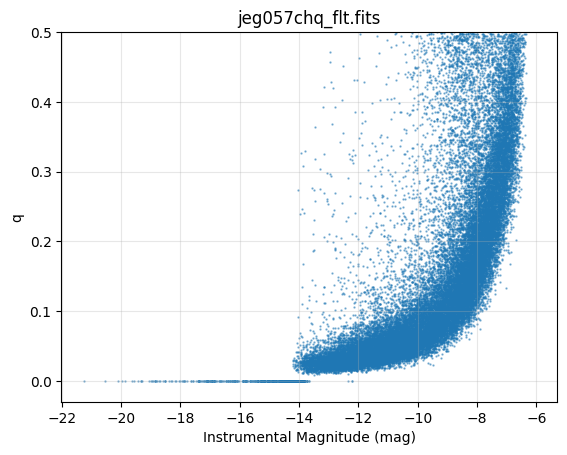

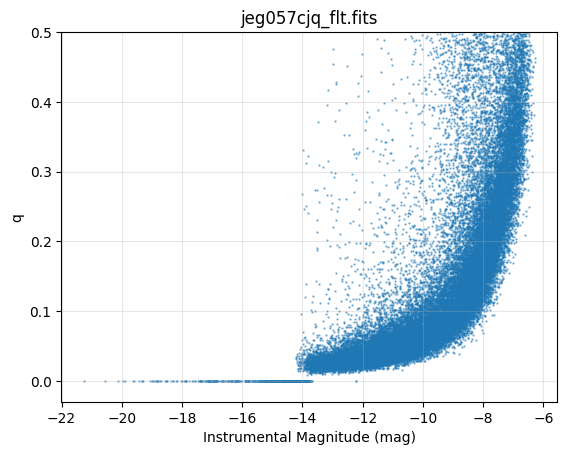

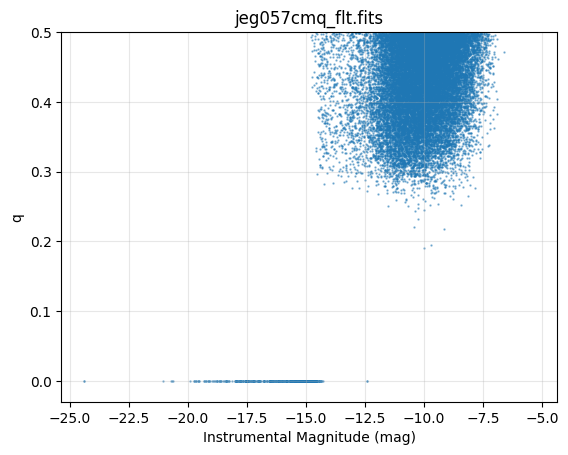

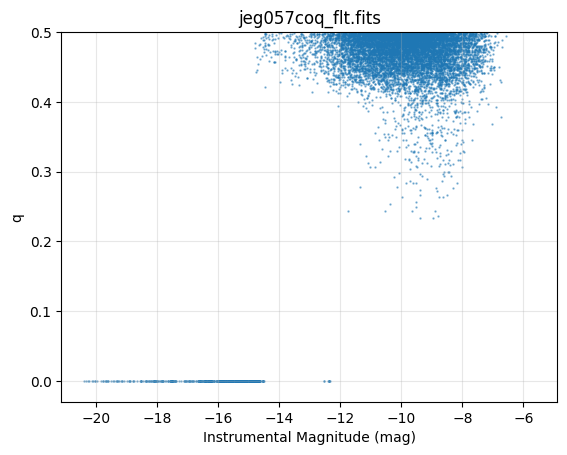

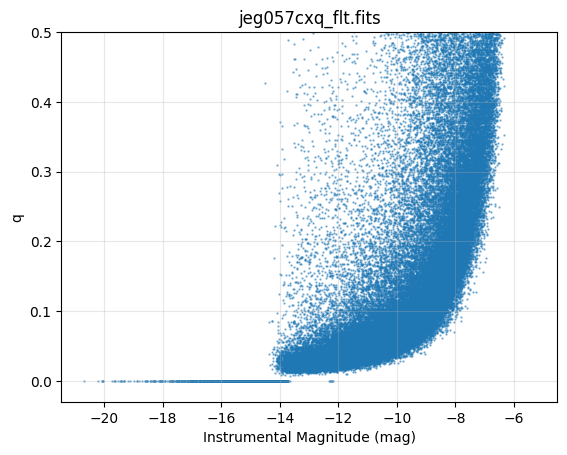

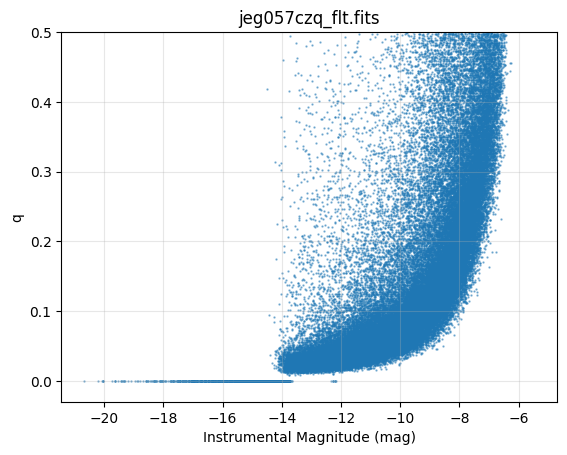

In [15]:
for flt in flt_files:

    root = flt.split('/')[-1].split('_flt.fits')[0]

    tab = ascii.read(f'{root}_flt.xymeq', names=['x', 'y', 'mag', 'error', 'q'])

    plt.figure()

    plt.scatter(tab['mag'], tab['q'], 2, alpha=0.5, marker='.') 
    plt.ylim(-0.03, 0.5)

    plt.xlabel('Instrumental Magnitude (mag)')
    plt.ylabel('q')
    plt.title(f'{root}_flt.fits')
    plt.grid(alpha=0.3)

The above plots show a rather typical distribution of `q` as a function of instrumental magnitude for the first, second, fifth, and sixth images. Saturated stars on the lower left of the plots have `q` defined as 0. Bright, well-fit stars have `q` values <~0.2. 

As expected, the library PSF is not a good match for the smeared sources in the third and fourth images, in which all sources have `q` values above 0.2-0.3. Cosmic rays typically fall in this range too. 

<a id="summary"></a>
## 5. Summary & Additional Resources 

In this notebook, we've shown you how to download data from an ACS exception report, display that data and the observing log information, interpret the observing log information for guide star problems, plot and inspect jitter information, and if desired, run hst1pass to further investigate PSF quality in the images. 

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](https://hst-docs.stsci.edu/acsdhb).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the HST Knowledge Base and request additional help from experts.

Additional resources that may be helpful:
- [Hubble Observation Problem Report (HOPR)](https://www.stsci.edu/hst/observing/post-observation/reporting-problems)
- [ACS Anomalies and Artifacts](https://www.stsci.edu/hst/instrumentation/acs/performance/anomalies-and-artifacts)

<a id="about"></a>
## About this Notebook 
**Author:** Jenna Ryon, ACS Instrument Team <br>
**Updated On:** June 2025

 <a id="citations"></a>

## Citations
If you use Python packages for published research, please cite the authors. Follow these links for more <br>
information about citing packages such as `astropy`, `astroquery`, `matplotlib`, `photutils`, etc.:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `photutils`](https://photutils.readthedocs.io/en/stable/getting_started/citation.html)
* [Citing `scipy`](https://scipy.org/citing-scipy/)
<br>

### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](https://hst-docs.stsci.edu/acsdhb).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the HST Knowledge Base and request additional help from experts.

<hr>

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 